In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-resnet50-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 100s 11ms/step - loss: 1.0596 - acc: 0.7276 - val_loss: 0.8985 - val_acc: 0.7842
Epoch 2/100
9112/9112 [==============================] - 131s 14ms/step - loss: 0.4697 - acc: 0.8668 - val_loss: 14.6700 - val_acc: 0.0898
Epoch 3/100
9112/9112 [==============================] - 201s 22ms/step - loss: 0.3499 - acc: 0.8972 - val_loss: 0.3605 - val_acc: 0.9072
Epoch 4/100
9112/9112 [==============================] - 158s 17ms/step - loss: 0.2256 - acc: 0.9324 - val_loss: 4.1831 - val_acc: 0.4697
Epoch 5/100
9112/9112 [==============================] - 137s 15ms/step - loss: 0.2061 - acc: 0.9390 - val_loss: 0.6555 - val_acc: 0.8301
Epoch 6/100
9112/9112 [==============================] - 200s 22ms/step - loss: 0.1553 - acc: 0.9540 - val_loss: 0.2924 - val_acc: 0.9297
Epoch 7/100
9112/9112 [==============================] - 199s 22ms/step - loss: 0.1647 - acc: 0.9503 - val_loss: 0.3495 - v

9120/9120 [==============================] - 191s 21ms/step - loss: 0.2000 - acc: 0.9485 - val_loss: 0.2160 - val_acc: 0.9380
Epoch 14/100
9120/9120 [==============================] - 194s 21ms/step - loss: 0.1992 - acc: 0.9478 - val_loss: 1.0071 - val_acc: 0.7264
Epoch 15/100
9120/9120 [==============================] - 191s 21ms/step - loss: 0.2500 - acc: 0.9350 - val_loss: 0.2024 - val_acc: 0.9488
Epoch 16/100
9120/9120 [==============================] - 193s 21ms/step - loss: 0.2064 - acc: 0.9481 - val_loss: 0.2293 - val_acc: 0.9341
Epoch 17/100
9120/9120 [==============================] - 193s 21ms/step - loss: 0.1557 - acc: 0.9595 - val_loss: 0.2237 - val_acc: 0.9331
Epoch 18/100
9120/9120 [==============================] - 192s 21ms/step - loss: 0.3758 - acc: 0.9107 - val_loss: 0.2586 - val_acc: 0.9213
Epoch 19/100
9120/9120 [==============================] - 191s 21ms/step - loss: 0.5262 - acc: 0.9230 - val_loss: 0.2707 - val_acc: 0.9232
Epoch 20/100
9120/9120 [================

Epoch 94/100
9128/9128 [==============================] - 193s 21ms/step - loss: 0.0174 - acc: 0.9951 - val_loss: 0.3034 - val_acc: 0.9504
Epoch 95/100
9128/9128 [==============================] - 193s 21ms/step - loss: 0.0112 - acc: 0.9964 - val_loss: 0.3444 - val_acc: 0.9435
Epoch 96/100
9128/9128 [==============================] - 188s 21ms/step - loss: 0.0074 - acc: 0.9978 - val_loss: 4.5914 - val_acc: 0.6161
Epoch 97/100
9128/9128 [==============================] - 195s 21ms/step - loss: 0.0042 - acc: 0.9987 - val_loss: 2.8314 - val_acc: 0.7728
Epoch 98/100
9128/9128 [==============================] - 191s 21ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.2993 - val_acc: 0.9514
Epoch 99/100
9128/9128 [==============================] - 198s 22ms/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.2807 - val_acc: 0.9583
Epoch 100/100
1008/1008 [==============================] - 10s 10ms/step
[7] Test acurracy: 0.9583 (20198.3079 s)
Train on 9130 samples, validate on 1006 samples
Epoc

In [21]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9569


In [22]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

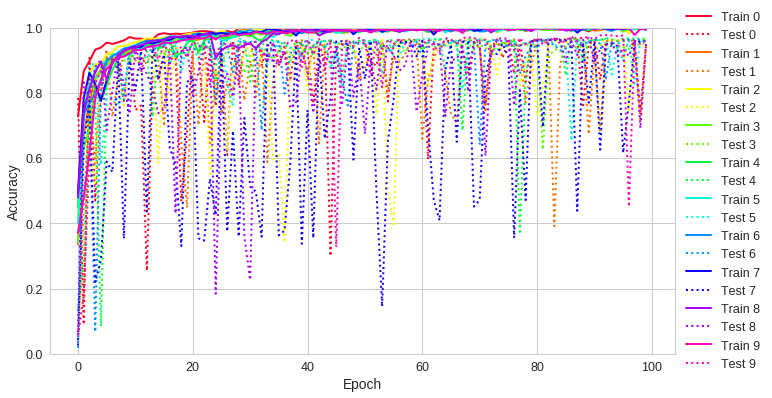

In [23]:
plot_acc(history)

In [24]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

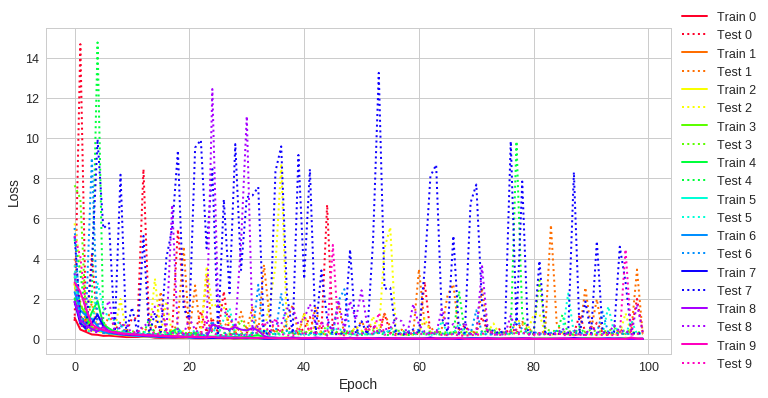

In [25]:
plot_loss(history)

Plotting the confusion matrix


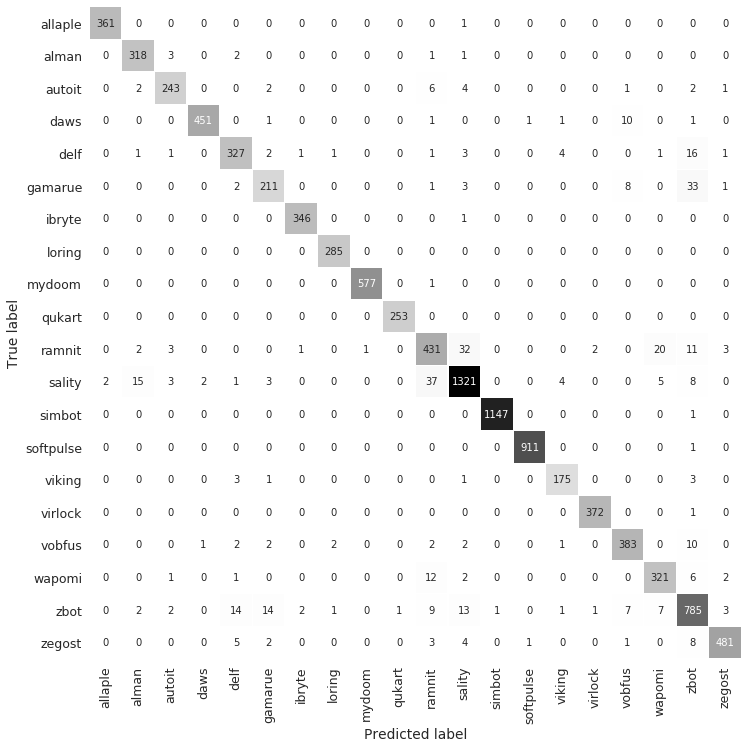

In [26]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


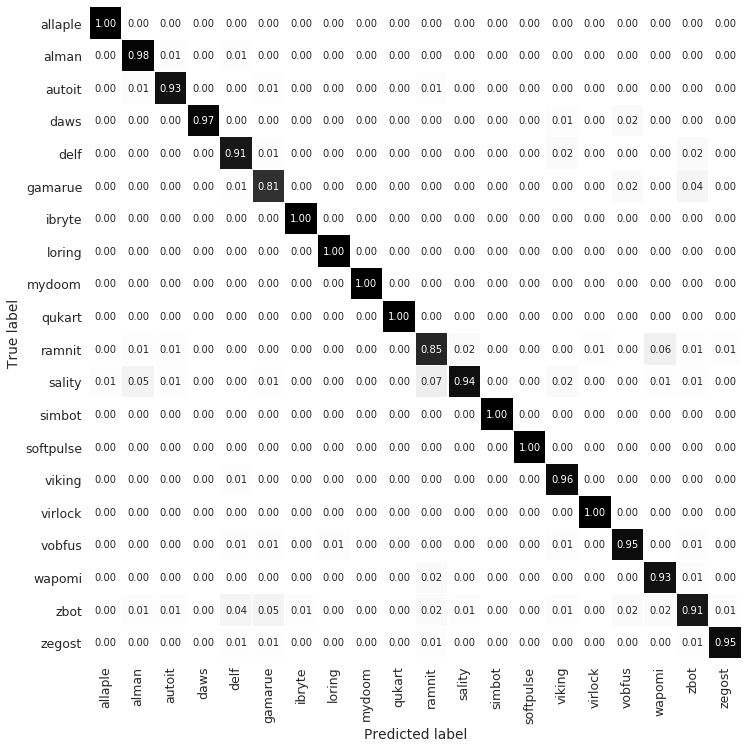

In [27]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
for h in history:
    print(h.history)

{'val_loss': [0.898502725282925, 14.669985242187977, 0.36049897204793524, 4.1830686257453635, 0.6554701578716049, 0.2924137345080453, 0.34948988727819597, 0.4065891205438277, 0.8532391268137189, 0.32519014497661836, 1.0275961247980376, 1.015656443360058, 8.451253313425696, 0.5383822218318528, 0.6097929732427474, 0.40646490236099453, 0.3981498793209539, 0.44019503728668496, 5.447234754945384, 2.1090131321107037, 0.26484051644638384, 0.3388668404646751, 1.3818002161278855, 0.31555304283654095, 1.0452428927528672, 0.27699105272677116, 2.366659419599273, 0.2228505549796176, 0.7005171964483452, 0.2833572604473602, 0.3032377544101834, 0.5352499954060761, 0.6043929737048614, 0.28827973531460405, 0.29107649977459005, 0.5013925327094739, 0.3831676063426812, 0.6832978478759628, 0.3048138574199397, 0.32538174512039575, 0.5129001642038382, 1.0914231635406395, 0.33665252927835354, 0.2895027308633509, 6.6807565247363385, 0.3686071348612803, 0.29904169281778126, 0.27492063689406887, 0.366514518219929

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

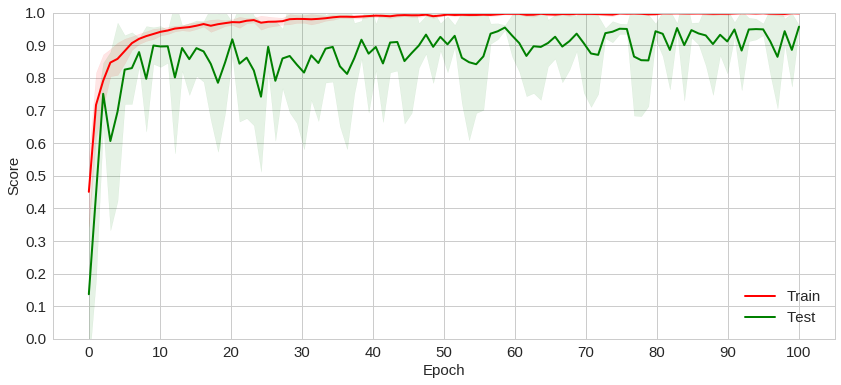

In [30]:
plot_mean_acc(history)

In [31]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

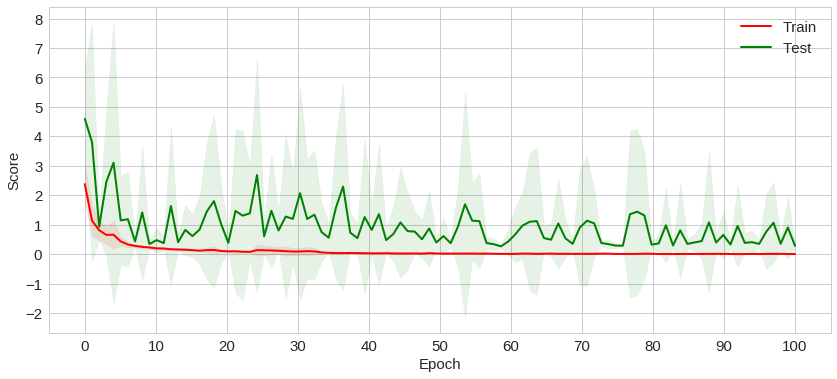

In [32]:
plot_mean_loss(history)

In [33]:
hist = [{'val_loss': [0.898502725282925, 14.669985242187977, 0.36049897204793524, 4.1830686257453635, 0.6554701578716049, 0.2924137345080453, 0.34948988727819597, 0.4065891205438277, 0.8532391268137189, 0.32519014497661836, 1.0275961247980376, 1.015656443360058, 8.451253313425696, 0.5383822218318528, 0.6097929732427474, 0.40646490236099453, 0.3981498793209539, 0.44019503728668496, 5.447234754945384, 2.1090131321107037, 0.26484051644638384, 0.3388668404646751, 1.3818002161278855, 0.31555304283654095, 1.0452428927528672, 0.27699105272677116, 2.366659419599273, 0.2228505549796176, 0.7005171964483452, 0.2833572604473602, 0.3032377544101834, 0.5352499954060761, 0.6043929737048614, 0.28827973531460405, 0.29107649977459005, 0.5013925327094739, 0.3831676063426812, 0.6832978478759628, 0.3048138574199397, 0.32538174512039575, 0.5129001642038382, 1.0914231635406395, 0.33665252927835354, 0.2895027308633509, 6.6807565247363385, 0.3686071348612803, 0.29904169281778126, 0.27492063689406887, 0.36651451821992964, 0.34124351781704565, 0.25865131885492154, 0.5209563559344588, 0.7097218763415825, 0.3102806445994797, 1.2555396240331902, 0.3104675523474363, 0.259495372456787, 0.23457071498211857, 0.23295267630518834, 0.2471286344240422, 0.2498187483004557, 2.8502632414456457, 0.2597861552893743, 0.31601748973792, 0.20439008324414143, 0.24657034027091562, 0.268053650633282, 0.455465148045918, 0.6743215668693665, 0.25179840872413317, 0.34192350829607765, 1.084190519140975, 0.333517358042311, 0.23892478491334312, 0.48631109308956244, 0.2550770806133551, 0.6183959050987142, 0.2937723076036898, 0.7600224530421009, 0.2657815168465447, 0.2344367721399152, 0.27034977795356596, 0.26471688495888124, 0.25852495787620944, 0.2561904821421397, 0.2558227850930481, 0.25545073818483166, 0.26520665863268134, 1.2066131596984633, 0.3497326729653656, 0.28656727203534693, 0.8078412474128029, 0.33075443746327515, 0.29094082001922095, 0.28653015736861187, 0.2760428471830898, 0.2751617881218178, 0.43632221576830776, 1.9945604440539895, 0.3118816668023521], 'acc': [0.7276119402985075, 0.866769095802642, 0.8971685690247667, 0.9323968394374094, 0.9389815627743635, 0.9540166813517161, 0.950285338068134, 0.9550043899202891, 0.960820895522388, 0.971027216856892, 0.9665276558907855, 0.9663081650570676, 0.9613696225805174, 0.9646619842489944, 0.9796971027216856, 0.9828797191564612, 0.9798068481123793, 0.9814530290774445, 0.9804653204565408, 0.9820017559785817, 0.9847453906935909, 0.988476733977173, 0.9894644425980766, 0.9877085162423178, 0.9838674276203728, 0.9827699736611062, 0.9895741878841089, 0.9854038630377524, 0.9961589113257243, 0.9929762951002715, 0.9935250220537395, 0.986501316997019, 0.9930860403863038, 0.983977173063397, 0.9936347674444331, 0.994622475856014, 0.9964881474978051, 0.9919885864793678, 0.9959394205443372, 0.9949517121327561, 0.99571992976295, 0.9930860404909652, 0.9893546971027217, 0.9941834942932397, 0.987379280070237, 0.9900131694468832, 0.9964881474978051, 0.9974758560140474, 0.9953906935908692, 0.9960491659350307, 0.9936347673397717, 0.9983538191395961, 0.9950614574187884, 0.9981343283582089, 0.9916593503072871, 0.9947322212467077, 0.9985733099209834, 0.9995610184372257, 0.9998902546093064, 0.9997805092186128, 0.9998902546093064, 0.990891132572432, 0.9871597892888498, 0.9973661106233538, 0.9958296752583049, 0.9982440737489026, 0.9995610184372257, 0.9984635646349511, 0.9913301141352063, 0.9965978928884986, 0.9974758560140474, 0.9971466198419666, 0.9948419666374012, 0.9992317822651449, 0.9982440737489026, 0.9969271290605795, 0.9990122914837577, 0.9985733099209834, 0.9945127305699818, 0.9928665496049166, 0.9985733099209834, 0.9993415276558385, 0.9996707638279192, 0.9998902546093064, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9998902546093064, 0.9940737489025461, 0.9882572431957858, 0.9982440737489026, 0.9984635645302897, 0.9974758560140474, 0.9981343283582089, 0.9997805092186128, 0.9998902546093064, 0.9998902546093064, 0.9967076382791923, 0.9953906935908692, 0.9984635645302897], 'val_acc': [0.7841796875, 0.08984375, 0.9072265625, 0.4697265625, 0.830078125, 0.9296875, 0.90625, 0.9013671875, 0.7705078125, 0.923828125, 0.7470703125, 0.76171875, 0.2548828125, 0.8486328125, 0.84375, 0.9228515625, 0.9033203125, 0.9072265625, 0.4677734375, 0.6787109375, 0.9365234375, 0.921875, 0.7109375, 0.94140625, 0.759765625, 0.9375, 0.609375, 0.9609375, 0.826171875, 0.9501953125, 0.9541015625, 0.8935546875, 0.8828125, 0.9453125, 0.9482421875, 0.8857421875, 0.927734375, 0.8447265625, 0.9560546875, 0.9462890625, 0.927734375, 0.767578125, 0.939453125, 0.94921875, 0.2998046875, 0.9375, 0.9501953125, 0.9609375, 0.9423828125, 0.9541015625, 0.9541015625, 0.89453125, 0.8828125, 0.9609375, 0.7734375, 0.94921875, 0.962890625, 0.9609375, 0.96484375, 0.958984375, 0.9638671875, 0.5966796875, 0.9501953125, 0.9462890625, 0.958984375, 0.958984375, 0.95703125, 0.935546875, 0.861328125, 0.95703125, 0.9384765625, 0.7646484375, 0.9384765625, 0.9638671875, 0.9072265625, 0.9619140625, 0.8583984375, 0.9609375, 0.833984375, 0.9560546875, 0.9638671875, 0.9609375, 0.962890625, 0.9658203125, 0.9638671875, 0.9638671875, 0.9677734375, 0.9677734375, 0.7548828125, 0.94921875, 0.9599609375, 0.8408203125, 0.9599609375, 0.962890625, 0.9599609375, 0.9599609375, 0.9619140625, 0.9404296875, 0.7431640625, 0.9521484375], 'loss': [1.0595953004521377, 0.46973470583414173, 0.3499392885665709, 0.2255691093432736, 0.20613789387027667, 0.15526202120233565, 0.1647285941082255, 0.14332997139880174, 0.11738370455101564, 0.09564066350564714, 0.09915853645840596, 0.10361810231293511, 0.11737345084380375, 0.1096886114386598, 0.06485203350403553, 0.05778029869303199, 0.06133020740624638, 0.059481119313784254, 0.057924671092968436, 0.05401384488986503, 0.04701443986333105, 0.03709129538679172, 0.0350788006049199, 0.04008553244504273, 0.050893201269401535, 0.05778308574932434, 0.036457650804832084, 0.04276854703878441, 0.013784211421559877, 0.021680634297952594, 0.023265212113793537, 0.044375100118732386, 0.02193931257168258, 0.05668303128446373, 0.02018091036876857, 0.016234644014103468, 0.011083082000701424, 0.02318606265902125, 0.011848841188704181, 0.017326133098755105, 0.015193207774596363, 0.021161713904520367, 0.03490704455398564, 0.02295848189425671, 0.04632833552863594, 0.030347718642760483, 0.011649711982775349, 0.007609250088240544, 0.01625482080449853, 0.01061594288081073, 0.01999117628347816, 0.005872165563943224, 0.019430885970339228, 0.00719115085462343, 0.029831509735470274, 0.01891575330020149, 0.005773986610564445, 0.0020385265088295533, 0.0010417654975284855, 0.0008589840814320061, 0.0006747413664902903, 0.03667247148875094, 0.04751877458443252, 0.013093850401970234, 0.013709681907678063, 0.005990450556016167, 0.0020379005488966413, 0.0061356499420980384, 0.023933670740053387, 0.00975739655903316, 0.007914688818611796, 0.010253028955842361, 0.02032530504678652, 0.003933820943994738, 0.00865059457502766, 0.00846615630904761, 0.0037939264358700033, 0.004012806923345059, 0.02593167895260856, 0.028980155248282756, 0.0045034657891060495, 0.0020244682830387463, 0.0012221419937940752, 0.0007645437721142985, 0.0013010682467812426, 0.0008213317121191468, 0.0008397665088787659, 0.00074425418043528, 0.020436942021367397, 0.03720522551060348, 0.005879556768171356, 0.006180983525410292, 0.008201174095520273, 0.0064565128264895836, 0.001059385463038211, 0.0007595776352458857, 0.0006515085572699462, 0.013276771411810809, 0.01502944311881671, 0.0056077206723069055]},
{'val_loss': [3.997641373053922, 1.8301693030766077, 0.9029655572311286, 1.780509228371594, 0.46906545600779137, 0.32599747019096365, 1.2103189163296364, 0.5316635573664662, 0.2735616314596699, 0.2756701557668757, 0.3709747796466323, 0.27215875467934575, 0.5930519905779693, 0.2739510955676298, 0.44503435925553225, 2.3512127302740127, 0.3014948967866574, 0.21226791316389795, 0.8796111717838393, 4.601007043265549, 0.2637125676684173, 2.6626988313672975, 0.19326037630772533, 3.1564120566381284, 0.459002078906314, 0.935968343350752, 0.5098088722013485, 1.1541468102404977, 0.20539166486209864, 1.3540421079524378, 0.4486764876876862, 1.629148006164918, 0.3154294593346299, 3.689003385161004, 0.9804924356113787, 0.2891018654615424, 0.24318668836812146, 0.9405523719941083, 1.7023553471387376, 0.22953118178399143, 1.243097088281922, 0.2528692704571231, 1.6050271123161068, 0.23523703128222861, 0.2932384313772297, 0.5027197178519787, 1.6966772714911218, 0.2344306428378132, 0.3349819426831206, 0.5106847625145591, 0.8693830148452928, 0.4009665753020466, 0.5727566693811458, 0.2162775677985362, 1.2880421249314449, 0.5791383635821153, 0.4069243023173046, 0.46375783718666774, 0.2528413096204886, 0.2553495790715049, 3.4739725262208094, 0.704746349435449, 0.631347084774248, 0.2050297142348991, 0.5414562466974512, 2.196355040453068, 2.719680823018472, 0.22345939508086224, 0.22920540414954843, 0.23336283748450895, 0.44908093293840207, 2.544475593690163, 0.31489018975836675, 0.3212237650515031, 0.30223681592778034, 0.3160055301042159, 0.21109615222862368, 0.467339450111165, 0.8535498682866998, 0.6095936035879801, 0.22112512316649496, 0.2368553974508106, 0.4101820710325486, 5.673978803907166, 0.7945091315440859, 0.2672260277096802, 0.23872930035099538, 0.2205678296338976, 0.22084103273002226, 2.5598010040896875, 0.4698406829385705, 1.9827025676412242, 0.24535774733868737, 0.22376238005038782, 0.2633543831438166, 0.5091528064323045, 0.24332094192777018, 0.35957000671783934, 3.4553763177195735, 0.2175837105296928], 'acc': [0.3355277596478507, 0.6717138468813734, 0.770353302820644, 0.8458415625360626, 0.8709677421186011, 0.8946675446202469, 0.9052007900849753, 0.9022383147853494, 0.9190256747860435, 0.9273644943678879, 0.9321922317314022, 0.9383366250641283, 0.9409699363616414, 0.9497476410834392, 0.9461268380150242, 0.9536976081670469, 0.9592933947772657, 0.9527101164877035, 0.9615975424258207, 0.9624753127188073, 0.9609392145785528, 0.963462804568188, 0.9685099848221341, 0.9648891816752402, 0.9687294273463315, 0.9692780338857214, 0.9643405750312118, 0.9718016238753566, 0.9813473777523003, 0.9851876234364714, 0.9748738205874989, 0.9842001316655694, 0.9870528856703972, 0.9873820495940312, 0.9718016239669152, 0.9837612464340575, 0.9850779021285934, 0.9845292957723206, 0.9839806890498135, 0.9915514592933948, 0.9839806890498135, 0.9868334430546412, 0.9872723282861532, 0.9919903445249068, 0.9886987052885671, 0.9935264428351986, 0.983870967833494, 0.9860653938994953, 0.9938556067588326, 0.9889181479958816, 0.9955014263770025, 0.9937458854509545, 0.9945139347107389, 0.9884792627643697, 0.9885889839806891, 0.994623656005537, 0.995611147776439, 0.9956111476848803, 0.9925389510642967, 0.9983541803818301, 0.9967083607636603, 0.9865042791310072, 0.9942944919903445, 0.9975861312266843, 0.9986833443054641, 0.989137590520079, 0.9936361641430765, 0.9982444590739522, 0.9955014263770025, 0.9965986394557823, 0.999012508229098, 0.9924292297564187, 0.9960500329163924, 0.9917709019091507, 0.9956111476848803, 0.9978055738424402, 0.9975861312266843, 0.9974764099188063, 0.989247311827957, 0.9939653280667106, 0.9986833443054641, 0.9989027869212201, 0.9979152951503182, 0.9927583936800527, 0.9956111476848803, 0.9979152951503182, 0.9987930656133421, 0.999670836076366, 0.999670836076366, 0.9980250164581962, 0.9904542462146149, 0.9921000658327848, 0.9962694755321484, 0.9987930656133421, 0.999122229536976, 0.9971472459951722, 0.9935264428351986, 0.9979152951503182, 0.9956111476848803, 0.9971472459951722], 'val_acc': [0.03424657534246575, 0.45401174308269227, 0.7485322896281801, 0.5831702544031311, 0.8551859099804305, 0.9148727984344422, 0.7270058738742089, 0.843444227939016, 0.9168297455968689, 0.9207436399217221, 0.8992172211350293, 0.913894324853229, 0.8874755390936148, 0.9266144814090019, 0.8992172211350293, 0.6976516648048058, 0.9363992181542802, 0.9471624266144814, 0.649706457925636, 0.44814090252855754, 0.9187866927592955, 0.7015655585464433, 0.9530332681017613, 0.6457925643006416, 0.8708414886795611, 0.7348336604243388, 0.8307240704500979, 0.8052837589715558, 0.9471624266144814, 0.7769080248830836, 0.8982387484869612, 0.78767123427643, 0.9373776917354935, 0.5880626239422017, 0.8405088076619486, 0.9363992172211351, 0.9540117416829745, 0.8395303336141627, 0.8463796477495108, 0.9657534246575342, 0.8483365977113727, 0.9500978473581213, 0.6448140922357891, 0.9471624266144814, 0.9403131115459883, 0.9119373776908023, 0.8590998043052838, 0.9461839530332681, 0.9383561643835616, 0.8385518590998043, 0.87573385518591, 0.9207436399217221, 0.9168297455968689, 0.9569471624266145, 0.8023483365949119, 0.9060665362035225, 0.8953033268101761, 0.9178082191780822, 0.958904109589041, 0.9579256360078278, 0.659491195370773, 0.8405088077785917, 0.898238747553816, 0.9628180039138943, 0.8620352250489237, 0.731898240613844, 0.7123287693395074, 0.961839530332681, 0.961839530332681, 0.958904109589041, 0.9354207445730669, 0.740704503777909, 0.9510763209393346, 0.9461839530332681, 0.9510763209393346, 0.9530332681017613, 0.9637964774951077, 0.9158512720156555, 0.7710371842123058, 0.8825831702544031, 0.9647749510763209, 0.9637964774951077, 0.9422700587084148, 0.3913894336517543, 0.8874755381604696, 0.9608610567514677, 0.961839530332681, 0.9677103718199609, 0.9667318982387475, 0.6731898249245436, 0.9266144814090019, 0.678082191780822, 0.9579256360078278, 0.961839530332681, 0.958904109589041, 0.9050880626223092, 0.9657534246575342, 0.9549902152641878, 0.7113502938920038, 0.9549902152641878], 'loss': [2.7353888685462087, 1.1358180072241142, 0.8326386057914599, 0.588423364696624, 0.49254360686458726, 0.3795075735646642, 0.33162390865632413, 0.32950977740095244, 0.2753915426272074, 0.25265264265208176, 0.23043488397367015, 0.2097130790892363, 0.1970343806122593, 0.17256391240540947, 0.18589721446775517, 0.15528929386502927, 0.13590607458440676, 0.16616718797718247, 0.13111441392457246, 0.12293760689081318, 0.12238771674244295, 0.1125917646339883, 0.10098195871240559, 0.10848080144575062, 0.09081670152796369, 0.09975581064522725, 0.1250393652701119, 0.08294336095518526, 0.05917241336360479, 0.04913923233303587, 0.08278050297098298, 0.05110648996528792, 0.044936040739880556, 0.04006855970194217, 0.08821949876913551, 0.049993311639099376, 0.045802030590100636, 0.04737720315999439, 0.05052785936341226, 0.02848282424403595, 0.05428882690414497, 0.038182593214694804, 0.04047116404194904, 0.024168395647841543, 0.03255025625563234, 0.019161871824885535, 0.05457054827714227, 0.044011085038492326, 0.02082662189863747, 0.03366229777677659, 0.0152192629192281, 0.0207813023291424, 0.01470824156794508, 0.03649076577264751, 0.03634829416679268, 0.017659975759357942, 0.013999951763095125, 0.01444936063910755, 0.024444936363838928, 0.005962736118032148, 0.013474080208615272, 0.043533200149571315, 0.01942422328394499, 0.008994436388432852, 0.005111588359596677, 0.04416358153809535, 0.023349118939127535, 0.006420840639254683, 0.015906889127752278, 0.012135521129796776, 0.007622690261260011, 0.025361867488301746, 0.013346528255555878, 0.025115542951296865, 0.014974981563246689, 0.007500972435905152, 0.00728400763111384, 0.00843674554165943, 0.03659945705853844, 0.01864105771812602, 0.00462854624016925, 0.004934914990133607, 0.005406351840090873, 0.02204025595081604, 0.016136417849278738, 0.007482990500619018, 0.004427532544397853, 0.001987431996722046, 0.001241065573330378, 0.007056453320116389, 0.029983042401760498, 0.023144669825862246, 0.012724773500504275, 0.0035853059533067244, 0.0041870606433306555, 0.0070876097721755465, 0.02109466997974692, 0.008773978784560196, 0.017158358296942327, 0.009340773876359374]},
{'val_loss': [5.753692155258328, 3.632736639897613, 1.7981079227884538, 2.0105831258437212, 0.3810913760068954, 0.3082493690278509, 0.27443138124402977, 0.45321797331174213, 1.993228718236673, 0.25485702082945616, 0.18133957306854426, 0.20974971074108764, 0.17591429331143588, 0.188013182836813, 3.0032678187368256, 0.26142746968251623, 1.8803011204934947, 0.22145293490340437, 0.3285575300471072, 0.39433168720865713, 0.1966206481256271, 0.29404623718678613, 0.2256295930112566, 3.610389106822949, 1.5911363601285107, 1.7508408267288378, 1.5936029712030408, 0.6489685952834371, 0.43236663440862755, 0.388519644685834, 0.22232866561516143, 1.1095363245666365, 0.37105546320866306, 0.4088200694774095, 1.7605544784015008, 3.622672637078715, 8.724304409120597, 0.3678195533453297, 0.23979031763664058, 0.2585431158585674, 1.2869325459240843, 0.27082322468881653, 0.6546412395483457, 0.2601911826804223, 0.24037943982035787, 0.3151395939645873, 0.2253560650768675, 0.22961758838001942, 0.24421568318387865, 0.619443660240312, 0.4169597992248956, 0.25831719381429263, 1.1268567991972553, 0.22382894575966752, 4.507001416505698, 5.553455248134846, 0.23135582622451373, 0.21253009395744116, 0.21319196087902573, 0.21493643712683122, 0.3215615429481935, 1.0329288818472557, 0.3532250350411999, 0.2896958875050484, 0.27789601523976154, 0.2621094602673187, 0.22348638963954398, 0.21748667520145426, 0.21302562462828883, 0.2105031964676523, 0.20846526910284893, 0.21222564323231033, 0.35876754744256145, 0.7734237262629333, 0.2344837553589077, 0.2603880591643679, 0.2107465927257622, 0.9727416590890903, 0.789762385027731, 0.4465067067129074, 1.2181129290636141, 1.2502373515906504, 0.2559134898907413, 0.2155001604099862, 0.2364999351921753, 0.2607809018938737, 0.22660892706049823, 0.22925050221764623, 0.2292633201514825, 0.22329836931989896, 0.2302828530801983, 0.23431923346085398, 0.22300369838785672, 0.23087577349891739, 0.22399679521493357, 0.2385042392685533, 1.280574895115341, 0.26051743307667474, 0.24613600191207752, 0.24253508637887705], 'acc': [0.4246379992531914, 0.7891619132244048, 0.8598069329699072, 0.8884379114430951, 0.8886573058882007, 0.9191531374978622, 0.926173760473545, 0.9422992542157209, 0.9439447126455504, 0.9497586660816147, 0.955682316910232, 0.9606186924089513, 0.9674199210179903, 0.9658841597191751, 0.9665423432375685, 0.969394471311632, 0.9721369023592967, 0.9665423433421839, 0.9753181220879414, 0.9802544976389685, 0.9827775340061431, 0.9835454147078584, 0.9827775340584508, 0.9791575252303641, 0.9825581395871914, 0.9905660377358491, 0.984752084247477, 0.9710399297937692, 0.9919921018513423, 0.990895129442738, 0.992211496270294, 0.9916630101444533, 0.9930890741553313, 0.9834357175245364, 0.9889205792537118, 0.9877139096094778, 0.993418165914528, 0.9827775340061431, 0.9956121105748135, 0.9929793769197016, 0.9865072400698592, 0.9940763492759982, 0.9979157525230364, 0.9948442299777136, 0.9958315050460729, 0.9911145239139973, 0.998025449758666, 0.9974769635805177, 0.9969284774023695, 0.9890302764370338, 0.992211496270294, 0.9981351469942957, 0.9958315050983806, 0.9987933304080737, 0.9987933304080737, 0.9890302764370338, 0.9927599824484423, 0.9972575691092584, 0.998354541465555, 0.9976963580517771, 0.9951733216846026, 0.9965993856954805, 0.998025449758666, 0.9959412022817025, 0.9901272488456381, 0.9949539271610356, 0.9974769635805177, 0.999670908293111, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.999670908293111, 0.9995612110574813, 0.984093900833699, 0.9949539271610356, 0.9978060553397144, 0.998683633172444, 0.9989030276437034, 0.9976963580517771, 0.9952830188679245, 0.9968187801667397, 0.9951733216846026, 0.9974769635805177, 0.998683633172444, 0.9985739359368144, 0.9994515138218517, 0.9995612110574813, 0.999670908293111, 0.9997806055287407, 0.999670908293111, 0.999670908293111, 0.9997806055287407, 0.9997806055287407, 0.9997806055287407, 0.999670908293111, 0.9997806055287407, 0.9820096533567354, 0.9970381746379992, 0.999012724879333, 0.999670908293111], 'val_acc': [0.056862745098039215, 0.29803921615376194, 0.6088235308142269, 0.524509804389056, 0.8901960803013221, 0.9049019614855448, 0.9245098053240308, 0.8627450999091654, 0.754901962186776, 0.9235294131671681, 0.9500000009349748, 0.936274510271409, 0.9509803926243502, 0.9509803926243502, 0.5852941181145462, 0.9343137264251709, 0.7980392166212493, 0.9441176484612858, 0.9205882359953488, 0.9127450989741905, 0.9558823538761513, 0.9333333340345644, 0.9411764710557227, 0.5441176479937984, 0.870588235761605, 0.8254901970134062, 0.626470589170269, 0.8980392170887367, 0.8921568641475602, 0.912745098506703, 0.9568627455655266, 0.82156862932093, 0.9264705889365252, 0.8843137273601457, 0.5950980396831737, 0.614705883287916, 0.34117647245818494, 0.9205882362290925, 0.9509803930918376, 0.9460784323075239, 0.8078431386573642, 0.9490196087781121, 0.8970588246981303, 0.9558823538761513, 0.9529411774055631, 0.9401960793663474, 0.9588235303467395, 0.9637254906635658, 0.9549019621867759, 0.8715686283859552, 0.9009803930918375, 0.9529411774055631, 0.7352941171795714, 0.9676470592910168, 0.5058823543436387, 0.39705882423064287, 0.9539215695624258, 0.9607843151279524, 0.960784314660465, 0.9549019617192885, 0.9372549033632466, 0.818627451915367, 0.9294117661083445, 0.9372549033632466, 0.9480392166212493, 0.950980393559325, 0.9637254906635658, 0.9617647063498403, 0.9656862749772913, 0.9647058828204286, 0.9666666671341541, 0.9647058828204286, 0.943137256304423, 0.8558823543436387, 0.9539215695624258, 0.9539215695624258, 0.9617647068173277, 0.8235294119984495, 0.8941176479937983, 0.9166666676016415, 0.7303921587326947, 0.817647060693479, 0.947058824931874, 0.9598039225036022, 0.9578431381898768, 0.9519607857161877, 0.9598039225036022, 0.9617647068173277, 0.960784314660465, 0.964705883287916, 0.960784314660465, 0.960784314660465, 0.9617647068173277, 0.9617647068173277, 0.9627450989741905, 0.9617647068173277, 0.7460784327750113, 0.9558823538761513, 0.9598039225036022, 0.9627450989741905], 'loss': [2.762906591010334, 0.7366004796758353, 0.5028289917165012, 0.41381450072617426, 0.4165419729237705, 0.32522405147186334, 0.25769127046868384, 0.22206519410739922, 0.21120264769882002, 0.1767757080579949, 0.16480530611108196, 0.15358517176507203, 0.11399980921652977, 0.12452947236466769, 0.11588791945516841, 0.12214589908967524, 0.10020134161574216, 0.11514483538495901, 0.08640352319664485, 0.06577775473843324, 0.06343777064949571, 0.0628978352097855, 0.06406591708095358, 0.07367301248026233, 0.057342221239559635, 0.03331199358242959, 0.0554799343306165, 0.11187200740695093, 0.029786974908240522, 0.028818798499758477, 0.026838786550401637, 0.02926176011576344, 0.02492848673898023, 0.06068790047677759, 0.03321067541314615, 0.04267432912039935, 0.02636662071323314, 0.06275786655063538, 0.016017072292863293, 0.0227010294768295, 0.050359901763311975, 0.022422720816288492, 0.005921057171240577, 0.01751376957981975, 0.017458812977203322, 0.03078535503564082, 0.0076966364585706664, 0.00724773902772559, 0.011570140036974269, 0.03436529185925615, 0.025068531386871613, 0.007734763670417636, 0.01482152956517061, 0.006039438790753064, 0.0045144283682114796, 0.03379571415411441, 0.024726605637684605, 0.008341945155668074, 0.0067128233913081, 0.006634267655372265, 0.015138305561501725, 0.011355182320881015, 0.006201756944838169, 0.01294513946745676, 0.029791831984910425, 0.018923587202040962, 0.00827849673044321, 0.0017006480091913785, 0.0014344201150742935, 0.0011712159201790109, 0.00087856692359576, 0.0010785093934484178, 0.00169339521029839, 0.05387324948170972, 0.015560396324126797, 0.00860809211675433, 0.00512956040989803, 0.005335681267512933, 0.007234641571832527, 0.013356632279134221, 0.010717260814526957, 0.014978960710514964, 0.007423798505462744, 0.003221177629960371, 0.006268492294688703, 0.0019260239354785184, 0.0017975695676159095, 0.0010556809038633837, 0.0009466386999946795, 0.0008503684118769199, 0.0007935445983189592, 0.0009807571458447992, 0.0008262725111699993, 0.0008318279419769307, 0.001002432962051532, 0.0008339682150259823, 0.06477723428139293, 0.010450113215014411, 0.003047810627488194, 0.0014342016009637306]},
{'val_loss': [7.64920869962437, 6.982387324956458, 0.9355370490041774, 0.6476788130830827, 0.5032254485816761, 0.479822545030015, 0.4111140447808636, 0.3852331194307978, 0.37693588597714933, 0.3693390812827494, 0.376775575590901, 0.3771552577608826, 0.34539707155384197, 0.36291965343723603, 0.3042301421958039, 0.3103989445978695, 0.334831938017027, 0.35003642120847056, 0.33827107796889283, 0.30138056910366806, 0.2783879000559871, 0.3314403717362099, 0.25464496370297385, 0.2775826136525118, 0.7635942352336694, 0.5012310752336923, 0.30926199859244236, 0.27391618045406024, 0.29975006847596913, 0.9458237307089588, 0.4325507956310336, 0.26391684422050793, 0.2926099147420712, 0.3659886029557206, 0.4695337186188935, 0.387267334414296, 0.3410866139022583, 0.44531825992923296, 0.3043787786501345, 0.44077285419199297, 0.31221936123578764, 0.38917568842095746, 0.3143695836830732, 0.3019566796613713, 0.6813528930876084, 0.37893059375547383, 0.3226800831434577, 0.3819093456293251, 0.376641063473037, 0.41638285799450436, 0.3389125300321379, 0.37832464654592035, 0.42965367878661315, 0.3130208951552698, 0.37866313354719405, 0.31991642874075166, 0.38922776863671876, 0.42600014584794205, 0.3020204735199772, 0.27991467981256546, 0.3546089156141003, 0.32936017733235784, 0.3754015319425658, 0.32430275064652725, 0.3579390474234131, 0.3148800962701126, 0.3305050799064781, 0.3440865265415493, 0.33454376014365633, 0.3957193443042442, 0.31906031476285124, 0.38318573474298784, 0.555205495962655, 0.30061293837523034, 0.32859417896430504, 0.3419091832960915, 0.3626571093819163, 0.2997601006905663, 0.3949572199434291, 0.35133782920227247, 0.4091281820444961, 2.9186805292348033, 0.48642416212346895, 0.4075875288457378, 0.39344480281548516, 0.34781289150776823, 0.3891088305575888, 0.3642073876956129, 0.4720892572788411, 0.35121754649332354, 0.4604790851122353, 0.3697828638901228, 0.3786081215855512, 0.3964996228648683, 0.5516307103042963, 0.32557086602982344, 0.4526184959980452, 0.33424548419416605, 0.3277972206571762, 0.33433263821652326], 'acc': [0.3425438596491228, 0.6325657894736842, 0.6900219298245615, 0.8405701754385965, 0.8698464912280702, 0.8845394736842105, 0.9016447368421052, 0.9134868421052632, 0.9234649122807017, 0.9299342105263158, 0.937609649122807, 0.9359649122807018, 0.9460526315789474, 0.9484649122807017, 0.956359649122807, 0.9552631578947368, 0.9620614035087719, 0.962609649122807, 0.9664473684210526, 0.9645833333333333, 0.9596491228070175, 0.968859649122807, 0.9734649122807018, 0.9781798245614035, 0.9756578947368421, 0.9747807017543859, 0.9718201754385964, 0.9765350877192982, 0.9861842105263158, 0.9779605263157894, 0.9730263157894737, 0.9841008771929824, 0.9774122807017543, 0.9908991228070175, 0.9879385964912281, 0.9893640350877193, 0.9820175438596491, 0.9742324561403509, 0.987280701754386, 0.9890350877192983, 0.9945175438596491, 0.9824561403508771, 0.9884868421052632, 0.9933114035087719, 0.9917763157894737, 0.9839912280701755, 0.9928728070175439, 0.9947368421052631, 0.9892543859649123, 0.9898026315789473, 0.9953947368421052, 0.9947368421052631, 0.9870614035087719, 0.9925438596491228, 0.9955043859649123, 0.9940789473684211, 0.9946271929824562, 0.9898026315789473, 0.9940789473684211, 0.9990131578947369, 0.9942982456140351, 0.9933114035087719, 0.9963815789473685, 0.9966008771929824, 0.99375, 0.9881578947368421, 0.9946271929824562, 0.9991228070175439, 0.9980263157894737, 0.9967105263157895, 0.9949561403508772, 0.9970394736842105, 0.9929824561403509, 0.9898026315789473, 0.9983552631578947, 0.9993421052631579, 0.9969298245614036, 0.9921052631578947, 0.9968201754385965, 0.9992324561403508, 0.9992324561403508, 0.9925438596491228, 0.9924342105263158, 0.9936403508771929, 0.9963815789473685, 0.9987938596491228, 0.9984649122807018, 0.9987938596491228, 0.9952850877192982, 0.9946271929824562, 0.9964912280701754, 0.9968201754385965, 0.9990131578947369, 0.999561403508772, 0.9972587719298246, 0.9878289473684211, 0.9963815789473685, 0.9980263157894737, 0.999561403508772, 0.9992324561403508], 'val_acc': [0.05708661417322835, 0.1732283464566929, 0.6909448818897638, 0.8405511811023622, 0.8622047244094488, 0.8759842519685039, 0.8809055118110236, 0.8858267716535433, 0.8986220472440944, 0.9035433080252699, 0.904527559993774, 0.8917322834645669, 0.9025590551181102, 0.9025590551181102, 0.9242125984251969, 0.9153543311779894, 0.9330708661417323, 0.9202755905511811, 0.919291339521333, 0.9438976387339314, 0.9389763784220838, 0.9212598425196851, 0.9478346456692913, 0.9360236220472441, 0.8385826781040101, 0.8838582677165354, 0.9340551181102362, 0.9409448823590917, 0.9271653543307087, 0.860236220472441, 0.9192913385826772, 0.9438976377952756, 0.937007874015748, 0.9271653543307087, 0.9025590551181102, 0.9291338587370445, 0.9429133867654275, 0.8976377952755905, 0.9399606299212598, 0.922244094488189, 0.9468503937007874, 0.9163385826771654, 0.9498031496062992, 0.9458661417322834, 0.8868110236220472, 0.9183070866141733, 0.9419291343275956, 0.9399606299212598, 0.9281496067685405, 0.9232283469260208, 0.9507874015748031, 0.9330708661417323, 0.9261811028315327, 0.9429133858267716, 0.9360236220472441, 0.9458661417322834, 0.9458661417322834, 0.9242125984251969, 0.9498031496062992, 0.9438976377952756, 0.937007874015748, 0.9409448818897638, 0.9409448818897638, 0.9438976377952756, 0.9448818897637795, 0.9438976377952756, 0.9438976377952756, 0.9458661417322834, 0.9517716535433071, 0.9311023622047244, 0.9468503937007874, 0.9399606299212598, 0.9143700787401575, 0.9488188976377953, 0.9517716535433071, 0.9468503937007874, 0.9429133858267716, 0.9507874015748031, 0.9458661417322834, 0.9498031496062992, 0.9409448818897638, 0.6259842529071598, 0.9143700792094854, 0.9301181107055484, 0.9409448818897638, 0.9370078744850759, 0.9458661417322834, 0.9389763779527559, 0.9429133858267716, 0.9478346461386192, 0.9271653548000366, 0.9468503941701153, 0.952755905511811, 0.9527559059811389, 0.9212598425196851, 0.9389763779527559, 0.9350393700787402, 0.9488188976377953, 0.9488188976377953, 0.9517716535433071], 'loss': [3.083009842404148, 1.6577296223556786, 1.2292353729929841, 0.5406340388352411, 0.4335013143326107, 0.3720337457562748, 0.31983924164975946, 0.28854909547718993, 0.2519125862079754, 0.23999576522527558, 0.205810439625853, 0.21552828000368257, 0.17531878002184, 0.17064577661977526, 0.14714106849411077, 0.14060973710331479, 0.12438235523489614, 0.12012392070405839, 0.10788564112266166, 0.11357937983253547, 0.1274675964533041, 0.0957109502353297, 0.08610703120204179, 0.06909010099908827, 0.07146185767395716, 0.08099511187409231, 0.09036243233723533, 0.07082085167956456, 0.042028057676731824, 0.06533206970943546, 0.08371657952298656, 0.05172153961632336, 0.06860010303605936, 0.030943492576051012, 0.03474988310624388, 0.03387746133569938, 0.05315029301850142, 0.07840570420794712, 0.03634211461982902, 0.031222906428503623, 0.01761433583750132, 0.05264525195469328, 0.03645970951676422, 0.01944799877199234, 0.025764475634710644, 0.04669909084092196, 0.020137179239929793, 0.018087385911980832, 0.03955040824476511, 0.033316748781337016, 0.017536046955144245, 0.016114536363455587, 0.042740101818855146, 0.021529974552635268, 0.015277233302757005, 0.018498344456856376, 0.017042386862145546, 0.030669587399512366, 0.020255309303116007, 0.003943665380070901, 0.0203494322046154, 0.023909619824208722, 0.011276431069196853, 0.01110600600724163, 0.01956017107445325, 0.03993826448937047, 0.015082057258852026, 0.0031590834575198593, 0.007392064974989983, 0.011225157454783473, 0.015737694232238777, 0.008333374093784011, 0.020534194666926627, 0.030799406683217966, 0.004981828519050811, 0.0029590183506139796, 0.011885663519523516, 0.025674661345456436, 0.009247066530640854, 0.0027346976847212046, 0.002438506560999262, 0.026898289880471948, 0.022192880706088065, 0.02140876799458694, 0.011478422357145303, 0.004113530315355188, 0.003864272802970765, 0.004018497574031898, 0.013491016046362091, 0.022386793816931778, 0.011449178843407968, 0.010424427318799931, 0.0032666672555694133, 0.0014664522661130257, 0.0069482417061669625, 0.03897002576057658, 0.010619775937365168, 0.006164578015869394, 0.0017217001943775183, 0.002440463176731499]},
{'val_loss': [4.956764303793118, 3.279983358589683, 1.0422789779469723, 1.9158192763039035, 14.753768447815903, 0.8698123835217882, 0.3824541622582148, 0.2914201158028294, 0.25566346879900015, 0.3714825629135667, 0.2691727601098058, 0.24383356939179926, 0.21597466145698935, 1.0071181308140789, 0.2023597450561498, 0.2293295619796639, 0.22366767789255362, 0.2586163653912826, 0.27072699415666146, 0.3497274395112337, 0.16847479636079676, 0.19984171917207363, 0.22984005493000992, 0.2512753373938611, 0.3653988684378763, 0.2053539364261362, 0.1954242700843586, 0.23658975403310523, 0.24441729738618315, 0.1930365613232239, 0.5638754209356867, 0.26211476272863893, 0.25756168364324816, 0.20746219996715623, 0.22056152468642348, 0.2618426047707731, 0.263017994078321, 0.30336008595983777, 0.2519819307994064, 0.2566579754435899, 0.3163076841909948, 0.2778038955176579, 0.2030004294082037, 0.23425462611775344, 0.21937315185320808, 0.30878297841615593, 0.24571991125241774, 0.299523584571393, 0.24435425103221123, 0.19151152479616312, 0.20808733914247576, 0.2278992575073144, 0.23312458069084654, 0.3143928690427369, 0.21682917551403647, 0.1906252117788542, 0.262241299536754, 0.204196233410394, 0.19246819891548297, 0.2284476353763358, 0.34810591506683125, 0.2381145011336655, 0.22482806830055638, 0.25330461778435476, 0.20189581676838117, 0.31138446618610116, 0.2688329307260244, 2.3745251723054586, 0.23355286247361237, 0.2502123465060519, 0.23141180567208666, 0.22821649464804758, 0.4881000282880817, 0.4554566487699287, 0.29290334296909737, 0.3104176816595477, 0.24689025709271595, 9.829064395850686, 1.153239978607988, 0.2771384954176449, 0.2542226942053712, 0.26453124776008785, 0.23282741411479513, 0.24952574678649458, 0.23985514853913717, 1.2102531165830592, 0.24057540323969342, 0.2140950817917994, 0.615427743917261, 0.22942441448441644, 0.2598326046969094, 0.2683908758939921, 0.24333827244659256, 0.26083666930901966, 0.26258540347070614, 0.25460933527778223, 0.25156638284431354, 0.252615205933153, 0.26866013592090693, 0.2701214126509472], 'acc': [0.4479166666666667, 0.7471491228070175, 0.8241228070175438, 0.8175438596491228, 0.774780701754386, 0.8233552631578948, 0.8707236842105263, 0.9052631578947369, 0.9171052631578948, 0.9145833333333333, 0.9308114035087719, 0.9406798245614035, 0.9484649122807017, 0.9478070175438597, 0.9349780701754385, 0.9481359649122807, 0.9595394736842106, 0.9107456140350877, 0.9230263157894737, 0.9530701754385965, 0.9639254385964913, 0.9246710526315789, 0.9608552631578947, 0.9673245614035088, 0.9728070175438597, 0.969078947368421, 0.969078947368421, 0.9701754385964912, 0.9756578947368421, 0.9797149122807017, 0.9804824561403509, 0.9664473684210526, 0.9591008771929824, 0.9787280701754386, 0.9870614035087719, 0.9851973684210527, 0.9839912280701755, 0.9891447368421052, 0.9835526315789473, 0.9848684210526316, 0.9900219298245614, 0.987390350877193, 0.9828947368421053, 0.993859649122807, 0.9969298245614036, 0.9972587719298246, 0.9838815789473684, 0.9903508771929824, 0.9895833333333334, 0.9853070175438596, 0.9939692982456141, 0.9959429824561403, 0.993859649122807, 0.9930921052631579, 0.9881578947368421, 0.9973684210526316, 0.9866228070175439, 0.9947368421052631, 0.9969298245614036, 0.9989035087719298, 0.9940789473684211, 0.9864035087719298, 0.9951754385964913, 0.9979166666666667, 0.9989035087719298, 0.9963815789473685, 0.9936403508771929, 0.9899122807017544, 0.9915570175438596, 0.9955043859649123, 0.9957236842105263, 0.9960526315789474, 0.9981359649122807, 0.9984649122807018, 0.9975877192982456, 0.9901315789473685, 0.9981359649122807, 0.9960526315789474, 0.9913377192982457, 0.9956140350877193, 0.9963815789473685, 0.9980263157894737, 0.9969298245614036, 0.9984649122807018, 0.999561403508772, 0.999561403508772, 0.9885964912280701, 0.9981359649122807, 0.9945175438596491, 0.9923245614035088, 0.9981359649122807, 0.9987938596491228, 0.999671052631579, 0.9994517543859649, 0.9997807017543859, 0.999671052631579, 0.999671052631579, 0.999671052631579, 0.999561403508772, 0.9997807017543859], 'val_acc': [0.1377952755905512, 0.28641732330397357, 0.7509842524378318, 0.7578740162173594, 0.08464566929133858, 0.826771654012635, 0.8897637799968869, 0.9163385836158212, 0.9291338587370445, 0.8937007883402306, 0.9271653548000366, 0.9350393705480681, 0.9379921264535799, 0.7263779532252335, 0.9488188981071232, 0.934055119048892, 0.9330708670803881, 0.921259842989013, 0.9232283469260208, 0.9143700792094854, 0.9566929138551546, 0.950787402044131, 0.9370078744850759, 0.9409448828284196, 0.8799212607811755, 0.9429133862960996, 0.9606299217291704, 0.9458661422016114, 0.9438976387339314, 0.9606299217291704, 0.8346456702299944, 0.9389763784220838, 0.9448818902331074, 0.9625984256661783, 0.9616141741670022, 0.9576771658236586, 0.9478346466079471, 0.9370078744850759, 0.9557086618866507, 0.9527559059811389, 0.9192913390520051, 0.9458661426709393, 0.9586614177921625, 0.9596456697606665, 0.9596456697606665, 0.950787402044131, 0.9527559064504668, 0.9340551185795641, 0.9576771662929865, 0.9606299221984983, 0.9616141741670022, 0.9586614182614904, 0.965551182041018, 0.9370078749544039, 0.9616141736976743, 0.9616141736976743, 0.950787402044131, 0.9606299217291704, 0.9606299221984983, 0.9625984261355062, 0.9301181107055484, 0.9596456697606665, 0.9635826776346822, 0.9635826781040101, 0.9665354340095219, 0.950787402044131, 0.9586614182614904, 0.6850393705480681, 0.964566930072514, 0.9468503941701153, 0.9616141741670022, 0.9596456702299944, 0.9360236229858999, 0.9281496072378684, 0.9566929143244826, 0.9438976382646035, 0.964566930072514, 0.36712598519062434, 0.8503937017260574, 0.9625984256661783, 0.9625984261355062, 0.9586614182614904, 0.9625984256661783, 0.9645669296031861, 0.964566930072514, 0.8533464576315692, 0.9645669296031861, 0.968503937477202, 0.8956692922772385, 0.9606299217291704, 0.9625984261355062, 0.9616141736976743, 0.9685039379465299, 0.9645669296031861, 0.9586614177921625, 0.966535433540194, 0.9675196855086979, 0.966535433540194, 0.9665354340095219, 0.9645669296031861], 'loss': [2.016038019197029, 0.9121399536467435, 0.6346884124634559, 1.3178412602397434, 1.8864093602749339, 0.7122066698576275, 0.5241597394671357, 0.3616573977757964, 0.31057457393198684, 0.30784356348674025, 0.23805956449686436, 0.2322758405420341, 0.20003730887383744, 0.19921394000238363, 0.2500125988206843, 0.20641706669212956, 0.15574980932369567, 0.3757942658473264, 0.5261950023357936, 0.19282966669844953, 0.14551944216680632, 0.28366067158221675, 0.15195302853622197, 0.1366383385272664, 0.11865395890842927, 0.13018215028569102, 0.1262989553582054, 0.11851382639438829, 0.09495200222815599, 0.08242521362640617, 0.09537341221258158, 0.15276667670073119, 0.19111341333278178, 0.09032402781288654, 0.05562435051256774, 0.06485867932359198, 0.06046826801683525, 0.03992934455000387, 0.06292751595437152, 0.06399061952721687, 0.0378849423907109, 0.04170907186225553, 0.055240068573090086, 0.019338201026798823, 0.011884048915217455, 0.008498886942330149, 0.04919012714695112, 0.03164441334711706, 0.032403942207619954, 0.047810991856015776, 0.022124575795169223, 0.012985517337986956, 0.018945562052172855, 0.022220392509546383, 0.04023519529514408, 0.009805646245398461, 0.03992025543159782, 0.01511684619514486, 0.010357213636732348, 0.004241490534510823, 0.019012177872691768, 0.044807592909803545, 0.014512490750013584, 0.0069796519103986435, 0.005964606448517435, 0.013710665537419437, 0.01957896915286447, 0.03107062570803432, 0.026019978057005923, 0.015108918673771161, 0.012179283514131767, 0.010412777982019818, 0.006396870060891895, 0.005968169509873278, 0.007638155238545981, 0.028695201778684447, 0.0067775681087321, 0.011663311579400613, 0.028707299377491148, 0.013812954807715933, 0.013055935627326426, 0.006187797400052101, 0.009872753088957483, 0.004701235840814645, 0.001623496979092172, 0.001396069417302913, 0.03590263462023071, 0.0053338636752621885, 0.02040963250456046, 0.02504418185846206, 0.00525762619186903, 0.004632071012388463, 0.0016736487295020198, 0.0018078742075271804, 0.001361199946984271, 0.0010530389478178716, 0.0010751718170976538, 0.0009252392047911646, 0.0009967319868499208, 0.0008312383535507762]},
{'val_loss': [3.665926129598646, 1.0601806935405638, 0.40069396288662, 0.3766421425413307, 2.7969267910252427, 1.5632550168034467, 0.9820985384451264, 0.9437767137827685, 0.7249851901927994, 0.2922723092964153, 0.26740696668646985, 0.30889171428617335, 0.3613380976647699, 0.2639767682049921, 0.22262506056925976, 0.21183027720558306, 0.38243308784965235, 0.2161275848692654, 0.5356899865893864, 0.2019033132720233, 0.23004775562490712, 0.4337518618167784, 0.21729204531983237, 0.1930253238947925, 0.5386823131145521, 0.19933216379736182, 1.0090185054048204, 1.546981787896442, 0.17901308865385265, 0.2220054173538627, 0.2272839252309765, 0.21278444959578222, 0.3411023100739133, 0.45680405852438066, 0.1946426362479411, 0.27765297214477713, 0.19535955016343212, 0.3337094578500487, 0.35212954028646687, 0.4298378421540872, 0.20332891116019766, 0.19624274458137564, 0.2570751484758243, 0.24983139696539122, 0.5247371676426602, 0.3621616474851527, 0.5578181371830072, 0.24725934527193522, 0.2456936975476437, 0.22861181415163484, 0.24436510270815306, 0.22252698847105834, 0.2411038132525546, 0.44815334711909377, 0.2250666210633742, 0.5328877355572287, 0.44684855521285066, 0.24308267377538859, 0.3133851197855888, 0.2309310518043677, 0.24962676952498156, 0.22737743253633194, 0.20979784183994332, 0.22994414737427668, 0.8972462251467022, 0.2655969104585487, 0.2426082409679633, 0.7818077163324975, 0.24326278376377852, 0.22391613907780286, 0.2442734511060932, 0.260823930995934, 0.2506487790133736, 0.225499148933294, 0.22193461845338175, 0.2358114431323747, 0.25963963373674365, 0.3068811567646054, 0.27832192963606983, 0.28382938438779615, 0.2690889422994698, 0.23597562570769864, 0.2412612612978579, 0.3358531922444067, 0.3567298318999939, 0.33721232670305384, 2.2626541339037303, 0.25848837936187113, 0.2698526434567649, 0.29759148133864377, 0.21604012109336268, 0.2356081762822197, 0.23153166771115627, 1.6203511931115617, 0.3594117407020528, 0.6508175970529614, 0.21600198203239543, 0.9223792820519013, 0.25068663246546685, 0.2927972516125592], 'acc': [0.3995616438486805, 0.7215342465769755, 0.8147945205479452, 0.8721095890476279, 0.8903013698646467, 0.8946849315068494, 0.9179178082257101, 0.91802739726354, 0.9116712328832444, 0.9185753424722854, 0.9312876712394087, 0.9374246575407786, 0.9416986301435183, 0.9446575342482083, 0.948931506855847, 0.9463013698630137, 0.9601095890476279, 0.9515616438356165, 0.9673424657599566, 0.9596712328767123, 0.9726027397260274, 0.9705205479452055, 0.9743561643900936, 0.9694246575342466, 0.9774246575375126, 0.9604383561676496, 0.963068493163749, 0.9717260273972603, 0.9837808219178082, 0.983013698630137, 0.9850958904109589, 0.9858630136986302, 0.9888219178147512, 0.9774246575375126, 0.9711780821917808, 0.9846575342531073, 0.989041095896943, 0.9911232876842969, 0.9858630137051622, 0.9842191780887238, 0.9863013698695458, 0.9914520547945206, 0.9925479452054794, 0.9972602739726028, 0.9941917808284498, 0.9832328767188608, 0.9880547945205479, 0.9961643835681758, 0.9813698630136987, 0.9914520547945206, 0.9968219178147512, 0.9869589041161211, 0.9952876712459408, 0.9850958904109589, 0.9949589041095891, 0.9949589041095891, 0.9925479452120115, 0.9878356164383562, 0.9968219178212832, 0.9922191780821917, 0.9981369863013698, 0.9993424657534247, 0.9995616438356164, 0.9993424657599567, 0.9857534246575342, 0.9946301369863013, 0.9948493150750252, 0.9907945205479453, 0.9957260274037922, 0.9893698630202307, 0.9964931506914635, 0.9927671232876712, 0.9946301369928334, 0.9879452054859841, 0.9944109589041096, 0.9987945205479452, 0.9976986301369863, 0.9953972602739726, 0.9966027397260274, 0.9974794520613265, 0.9947397260273972, 0.9995616438356164, 0.9994520547945206, 0.9976986301369863, 0.9953972602739726, 0.9975890410958904, 0.9959452054794521, 0.9903561643835617, 0.9957260273972602, 0.9972602739726028, 0.9979178082191781, 0.9994520547945206, 0.9992328767123287, 0.9950684931506849, 0.9947397260273972, 0.9964931506849315, 0.997041095896943, 0.9943013698630137, 0.9983561643900937, 0.9934246575342466], 'val_acc': [0.12957467853610286, 0.689416419445702, 0.8842729978580267, 0.890207715546224, 0.5796241344318428, 0.7833827901428932, 0.7873392684641272, 0.7665677555237043, 0.8140454997412647, 0.9198813060506751, 0.926805143835047, 0.9119683485828215, 0.9080118698488947, 0.9337289816194189, 0.9485657764589516, 0.9446092981377177, 0.8882294761792606, 0.9455984174085065, 0.863501484033262, 0.9535113748763601, 0.9455984178211994, 0.9030662710187932, 0.9446092981377177, 0.9624134520276953, 0.8971315533305959, 0.9574678536102869, 0.8259149361199135, 0.7596439169139466, 0.9693372898120672, 0.9545004949725346, 0.9535113752890529, 0.956478734339498, 0.9357072209863823, 0.8852621166571665, 0.9584569732937686, 0.9357072209863823, 0.9574678540229797, 0.9376854599406528, 0.926805143835047, 0.9090009895323764, 0.9614243323442137, 0.9624134524403882, 0.9535113752890529, 0.963402571711177, 0.8743818006105168, 0.9208704253214639, 0.8189910983355415, 0.9594460929772503, 0.9495548961424333, 0.9574678536102869, 0.9594460933899431, 0.9574678540229797, 0.9624134520276953, 0.8585558860875026, 0.9604352130734248, 0.9139465879497849, 0.9119683485828215, 0.9535113752890529, 0.946587537504681, 0.9634025721238699, 0.9634025721238699, 0.966369931174315, 0.966369931174315, 0.9643916913946587, 0.8714144411473789, 0.9545004949725346, 0.9594460933899431, 0.811078140454995, 0.9643916913946587, 0.966369931174315, 0.9653808114908333, 0.9614243327569065, 0.9574678540229797, 0.9624134524403882, 0.9643916913946587, 0.9614243323442137, 0.9584569737064614, 0.943620178454236, 0.9564787339268052, 0.9485657768716445, 0.9584569737064614, 0.9624134524403882, 0.966369931174315, 0.9465875370919882, 0.943620178454236, 0.9416419390872726, 0.6538081107814046, 0.9624134524403882, 0.9574678540229797, 0.9594460933899431, 0.9624134524403882, 0.9624134524403882, 0.9653808110781404, 0.8565776458951533, 0.946587537504681, 0.897131552917903, 0.9693372902247601, 0.8288822951703586, 0.9643916913946587, 0.9515331355093967], 'loss': [3.2678000243853216, 1.0065550224095174, 0.7323156841356461, 0.4627267964408822, 0.40513929293906853, 0.38822900503628877, 0.28948347050849704, 0.2973226255782663, 0.32417081112404394, 0.29300836171842604, 0.2525164865728927, 0.23423479768674668, 0.23256713485064573, 0.20475533854144892, 0.18812463085618739, 0.18198087077393924, 0.15345904569429894, 0.14899326917233124, 0.0963064229961944, 0.13913227740501705, 0.0923855261275009, 0.08712373627296151, 0.08698102004479055, 0.10112132466012892, 0.07146838505953959, 0.127545222217906, 0.13291639067620448, 0.09697441868504433, 0.04821521272908335, 0.053749068471973076, 0.04790688695095173, 0.044703556813439994, 0.033670783821442354, 0.06907158506722891, 0.10115521836413505, 0.0481778650387152, 0.03321754192560911, 0.030021352391702772, 0.046575690413225596, 0.05163257114277923, 0.04208896775931528, 0.029309245471880862, 0.02211972688872639, 0.01014713088195924, 0.017550055933736698, 0.05380434363743622, 0.03632809969440919, 0.014314683788430507, 0.06006512760197463, 0.026926590358812924, 0.013204882289895354, 0.039562480584105914, 0.018210651120043372, 0.05418484411847918, 0.015432469494602554, 0.014296985793584472, 0.025149404909283128, 0.040046047864016145, 0.010831318954414089, 0.02730848263391638, 0.0074558150861113275, 0.002593318350190912, 0.0019475219244223523, 0.0026452342932533524, 0.0492155825864294, 0.020293061589598912, 0.015809053449690573, 0.033405594007456546, 0.017886719129341717, 0.0454946524316815, 0.01266328751633808, 0.02591873817061039, 0.01832288795620305, 0.040109010099280265, 0.020016579240959214, 0.003918862956715588, 0.00845892582016627, 0.014581835047305204, 0.020192908956396572, 0.0070201726428883735, 0.01858664516031053, 0.0024411862292236194, 0.0034930544259938233, 0.0077924774339815685, 0.01500894613407093, 0.007880953974373332, 0.015105686010080804, 0.03218877877726551, 0.01435811792339638, 0.007444453218318713, 0.007485374485521676, 0.0017576712552593201, 0.003155003725915664, 0.019594025212969376, 0.016149813591600684, 0.013530704796630794, 0.011979114852294689, 0.019354477480573784, 0.0053523096148234035, 0.019250203425058305]},
{'val_loss': [5.522841687244986, 0.7541929780550826, 1.221288278985056, 9.005894130710567, 0.7906407002946666, 0.2980666805568222, 0.2678632445245472, 0.32061493206064856, 0.6881043866601643, 0.20816815699698962, 0.24371224792137508, 0.2603612379547083, 0.22125411039376502, 0.2567996473265193, 0.2085130751545829, 0.1641464589518867, 0.17870604919006342, 0.318646206428665, 0.37385035626475815, 0.21148654374558704, 0.2611374460567426, 0.2689669755942427, 0.19421190381497427, 0.18094021628949536, 0.9077985837309814, 0.14601258792107907, 0.24177146894101167, 0.40803488155964684, 0.20091517060589464, 0.2002967766825057, 0.1901498434595185, 0.18720057145157637, 2.6977921691349347, 0.23895173326999808, 0.3704124727221633, 0.22008133203760327, 2.2754461548870384, 0.31270926456433884, 0.3342879400327532, 0.24098708272775787, 0.21554578687613282, 0.30803351613498553, 0.23182931848934255, 0.24425257527085628, 0.22088191230931767, 0.25675938452799413, 1.9059671627276602, 2.478549130535076, 0.23620669471951777, 0.27116646285895984, 0.3077354306496225, 0.2568512861431207, 0.2643589300439276, 0.2960973158432388, 0.3378844624318148, 0.39875352922520235, 0.32248489458167384, 0.24889572149792008, 0.4268271146615051, 0.2858044990255278, 0.4792264610318046, 0.27684603376211453, 0.272176877660318, 0.35735703490230414, 0.2771844040042569, 0.2299750593130078, 0.25940565378077535, 0.24951399475493372, 0.28123469290479985, 0.2694521436531682, 1.4284016616694164, 0.2692164155153769, 0.21023203008882588, 0.24248779852639546, 0.3531221551915389, 0.2919798695046701, 0.2949814968257978, 1.0302464156548887, 0.4627179390238508, 0.3163669754552107, 0.35417042369441043, 0.24972491582937886, 0.32172830668858476, 0.29475723756628386, 0.4069035242208919, 0.34341494816818424, 0.2119216894410805, 0.31504800892526774, 0.28541176716378314, 0.2707166825164706, 0.25830985858563804, 0.28901889916696755, 1.3612702495028075, 0.30177380855597596, 0.3306716047509245, 0.26211024648848846, 0.2589062138343876, 0.2717673386312308, 0.2672142927130576, 0.26140044731825185], 'acc': [0.48690697931833227, 0.7358387202902823, 0.7665169278097085, 0.8002629560774854, 0.8392681056729305, 0.8997480004382601, 0.9120192834447245, 0.9236331763423729, 0.936233154390184, 0.9401774953434864, 0.9460940068452763, 0.954311383806289, 0.9591322449874, 0.958693984932271, 0.9612139804974252, 0.9660348416785363, 0.9727183083159855, 0.973156568475604, 0.9664731018381546, 0.9645009313027282, 0.9792922099265914, 0.982469595705051, 0.9764435192286622, 0.9824695957572956, 0.9781965597104018, 0.9832365509451997, 0.9848800262956064, 0.9794017749534348, 0.9895913225021187, 0.9872904569384067, 0.9927687082283335, 0.9868521967787882, 0.985099156401538, 0.9846608962419195, 0.9903582776377781, 0.991892188013586, 0.9827982907855812, 0.9899200175304043, 0.9913443628924301, 0.9826887257587378, 0.9946313137369165, 0.9917826229867426, 0.9916730579729603, 0.9829078558124247, 0.9968226142215405, 0.9963843541141667, 0.9952887038457324, 0.9924400131478032, 0.9852087213761367, 0.9948504437383587, 0.9972608743811588, 0.9894817574230306, 0.9914539279062123, 0.9946313136846718, 0.9924400131478032, 0.9937547934699243, 0.9927687082283335, 0.9978086994631313, 0.9961652240604799, 0.9939739235236112, 0.995179138818889, 0.9947408787115153, 0.9962747890873234, 0.9962747890873234, 0.9951791388711337, 0.9884956721814396, 0.9986852196778788, 0.9994521748657829, 0.9993426098389394, 0.9994521748657829, 0.9883861071545963, 0.98882436726197, 0.996932179248384, 0.9989043497315657, 0.9983565245973485, 0.9976991344362879, 0.9984660896241919, 0.9944121836309849, 0.9957269639531061, 0.9981373945436617, 0.9981373945436617, 0.9970417442752273, 0.9990139147584091, 0.9955078338994193, 0.995179138818889, 0.9968226142215405, 0.9993426098389394, 0.9986852197301235, 0.9930974033088638, 0.9986852196778788, 0.9997808699463131, 0.9995617398926263, 0.9944121836309849, 0.989591322449874, 0.9979182645422194, 0.9948504437383587, 0.9997808699463131, 0.9996713049194696, 0.9997808699463131, 0.9998904349731565], 'val_acc': [0.017839444995044598, 0.7839444997407519, 0.7581764124666144, 0.06739345887016848, 0.8037661061178232, 0.9028741328047571, 0.9127849355797819, 0.8959365708622399, 0.7770069375619425, 0.9375619425173439, 0.933597621407334, 0.9345887016848364, 0.933597621407334, 0.929633300297324, 0.9435084241823588, 0.9464816650148662, 0.9524281466798811, 0.9127849355797819, 0.9058473736372646, 0.9425173439048563, 0.933597621407334, 0.9385530227948464, 0.9534192269573836, 0.9554013875123885, 0.77998017839445, 0.9613478691774033, 0.9425173439048563, 0.8632309227679719, 0.956392467789891, 0.956392467789891, 0.956392467789891, 0.9573835480673935, 0.6858275530950283, 0.9385530227948464, 0.9345887027481502, 0.9573835480673935, 0.7978196244528083, 0.9236868186323092, 0.9207135777998018, 0.9554013875123885, 0.9593657086223984, 0.9405351833498513, 0.958374628344896, 0.9395441030723488, 0.9613478691774033, 0.9514370664023786, 0.8434093161546086, 0.7611496531219029, 0.9554013875123885, 0.9504459861248761, 0.9504459861248761, 0.9534192269573836, 0.956392467789891, 0.9484638255698712, 0.923686819695623, 0.9425173449681701, 0.9444995044598612, 0.9603567888999008, 0.9385530227948464, 0.9573835480673935, 0.910802775024777, 0.9534192269573836, 0.956392467789891, 0.9464816650148662, 0.9474727452923687, 0.9573835480673935, 0.9593657086223984, 0.9593657086223984, 0.9573835480673935, 0.9544103072348861, 0.641228939780395, 0.9534192269573836, 0.9603567888999008, 0.9643211100099108, 0.9444995044598612, 0.9454905847373637, 0.9554013875123885, 0.8582755213804595, 0.9127849355797819, 0.9425173439048563, 0.9395441030723488, 0.958374628344896, 0.9534192269573836, 0.9474727452923687, 0.929633300297324, 0.9355797819623389, 0.9643211100099108, 0.9554013875123885, 0.9524281466798811, 0.9544103072348861, 0.9653121902874133, 0.9504459861248761, 0.8444003974954248, 0.9534192269573836, 0.9494549058473737, 0.9593657086223984, 0.9633300297324083, 0.9623389494549058, 0.9633300297324083, 0.958374628344896], 'loss': [2.3304840508773736, 1.4235628124812587, 1.1594048899523828, 0.9918254802087788, 0.6403101320411442, 0.335962595785645, 0.2866852133600869, 0.2521880112773711, 0.21155576755173225, 0.2002182689804465, 0.16589289634580665, 0.14938777648323726, 0.13496481070962932, 0.12738080310660882, 0.11829468250740778, 0.10446918912697635, 0.08819250675238496, 0.08017390279969341, 0.10830767605042711, 0.11659383916721472, 0.06025513215592535, 0.05420317715180827, 0.07207758966014989, 0.052897048012888276, 0.06524719795914391, 0.0522906009433439, 0.048647871438217534, 0.06475612661273016, 0.033857538419674336, 0.038904280975845494, 0.023407188994517946, 0.04179120193031827, 0.04959443006464515, 0.04696695769643035, 0.026447702165815188, 0.02559546120442863, 0.05127354977935899, 0.028308007872126298, 0.02687538786467491, 0.05267880920822176, 0.01800754870921949, 0.022444871262466803, 0.023940858759679464, 0.05596974020672, 0.010930123131026195, 0.012211304184726048, 0.015098060036022586, 0.024063798878089362, 0.04511272087434032, 0.014965293858474112, 0.00966702978249102, 0.03265481552699834, 0.027811135443045233, 0.018125112763992982, 0.02458036718950235, 0.01915708674647053, 0.02149910652734808, 0.006810585356488212, 0.014936647933569134, 0.015749067085746585, 0.017918118613065043, 0.015457928254759954, 0.010281536398102045, 0.012111103953569156, 0.014719677418030588, 0.04061164761071784, 0.0053711869646184, 0.0026837645379790306, 0.0020164739996826634, 0.0027701216061680215, 0.036721704009219494, 0.03325009876792996, 0.010136268920458836, 0.003981336790993804, 0.0054124095413715404, 0.007416179452221548, 0.006410265784832731, 0.017877618564595646, 0.014389308239965344, 0.006986664997301743, 0.0066657388818295, 0.0120516487075517, 0.0056166273097538934, 0.014729280760242512, 0.018061484995097347, 0.010085891189755013, 0.0026779155724283854, 0.004669670903535291, 0.025068593739043136, 0.0050951949080074495, 0.0014848702125433233, 0.0019486753522708915, 0.019651475096214475, 0.032128528038737836, 0.006725723688273713, 0.018833076479037914, 0.0014456811451774583, 0.0011349280108387276, 0.0011960476971013222, 0.0009615977488518047]},
{'val_loss': [5.09402655041407, 1.1159773393282815, 0.5970765374423492, 3.69612409387316, 9.942835189047313, 5.502123777178072, 5.760172262137371, 0.3690639654015531, 8.17254287814204, 0.34671860918890507, 1.56382349224083, 0.26078137824503667, 5.129301777789517, 0.1855558237954346, 1.2961720276429014, 0.340904219188757, 4.049561200031941, 5.492240695016727, 9.374960120767355, 1.4868957466115096, 1.0027179157893613, 9.521608708662884, 9.900351622541036, 4.51464306194398, 8.45146575511252, 0.28828069633556647, 6.944336728155909, 2.277849365663271, 9.695921630140335, 3.431003949765231, 7.056320417768484, 7.141253955677033, 7.560904472489797, 0.27552318183595137, 0.2658339737553982, 8.33167078275056, 9.581568573550959, 2.2362372453608637, 0.2788478461172908, 9.15507988069982, 2.9869504857030122, 8.44703148779231, 0.28436034694725154, 3.40843849757244, 1.0192870252524582, 0.23097293993272786, 0.24439421179675586, 0.29534649469346436, 4.4541328995854865, 0.26433350275629486, 0.879922667810841, 0.2278659026820102, 4.86624786161655, 13.239358894408696, 2.4923448037533547, 2.542611388669062, 0.2779207953233989, 0.2385327848647763, 0.24486319598120027, 0.4813033119932701, 0.2639463636443112, 3.4733150136266273, 8.10181742695637, 8.666362038403248, 1.0276034029118115, 0.3492813222510657, 5.130270802688341, 0.2877458690363085, 0.31860435269379694, 6.782905375933282, 7.685499458938249, 1.6728851034775958, 0.3628148924769763, 0.42931277527259676, 0.268778002307797, 0.4425451430245234, 9.833162112689948, 0.7145927512496045, 7.833544871610929, 0.25689879736388854, 0.2586202085306108, 3.8875429992693262, 0.25605685890546526, 0.25496629964699274, 0.25467226671236404, 0.26163371343564257, 0.2518436099690986, 8.296775221965083, 0.2676630420104267, 1.8704484171504328, 0.2687551393651593, 4.864261981044851, 0.3350582214341648, 0.3033880986862249, 0.3444429332130804, 4.591422648605575, 2.831441441357197, 0.2992993863737226, 0.280655701919052, 0.28973867773140344], 'acc': [0.4924408413672217, 0.7836327782646801, 0.8617440841367222, 0.8264680105170903, 0.7765118317265557, 0.838737949167397, 0.8964723926380368, 0.9119193689745837, 0.92988606485539, 0.9362401402278703, 0.9412795793163892, 0.9409509202453987, 0.9542068361086766, 0.9517966695880806, 0.9559596844872918, 0.9623137598597721, 0.9623137598597721, 0.9708588957055214, 0.971954425942156, 0.9723926380368099, 0.9665863277826467, 0.9796231375985978, 0.9788562664329535, 0.9842243645924628, 0.9817046450482033, 0.983567046450482, 0.9794040315512709, 0.9830192813321648, 0.9804995617879053, 0.9840052585451359, 0.9819237510955302, 0.9878396143733567, 0.9863058720420683, 0.9952892199824716, 0.9952892199824716, 0.9910166520595969, 0.9878396143733567, 0.9903593339176161, 0.9756792287467134, 0.994193689745837, 0.9968229623137599, 0.9967134092900964, 0.9928790534618755, 0.9888255915863278, 0.9925503943908852, 0.9985758106923751, 0.9992331288343558, 0.9991235758106923, 0.9795135845749343, 0.9943032427695004, 0.9937554776511832, 0.9967134092900964, 0.9961656441717791, 0.9877300613496932, 0.9926599474145487, 0.992988606485539, 0.9986853637160386, 0.9983567046450482, 0.9989044697633654, 0.9993426818580193, 0.9996713409290097, 0.9990140227870289, 0.9787467134092901, 0.9970420683610868, 0.9945223488168273, 0.9990140227870289, 0.9993426818580193, 0.9995617879053462, 0.9992331288343558, 0.990578439964943, 0.9918930762489044, 0.9981375985977213, 0.9957274320771253, 0.9973707274320771, 0.9991235758106923, 0.9993426818580193, 0.9934268185801928, 0.9983567046450482, 0.9934268185801928, 0.996603856266433, 0.9992331288343558, 0.9993426818580193, 0.9995617879053462, 0.9996713409290097, 0.9995617879053462, 0.9997808939526731, 0.9995617879053462, 0.98477212971078, 0.9980280455740579, 0.9990140227870289, 0.9996713409290097, 0.9994522348816828, 0.9973707274320771, 0.9950701139351447, 0.996384750219106, 0.9978089395267309, 0.9986853637160386, 0.9995617879053462, 0.9996713409290097, 0.9997808939526731], 'val_acc': [0.025793650793650792, 0.6458333333333334, 0.7748015873015873, 0.22023809523809523, 0.2876984126984127, 0.5892857142857143, 0.5575396825396826, 0.8978174603174603, 0.3531746031746032, 0.8988095238095238, 0.8075396825396826, 0.9285714285714286, 0.4365079365079365, 0.9444444444444444, 0.8412698412698413, 0.9176587301587301, 0.6309523809523809, 0.5813492063492064, 0.33035714285714285, 0.8323412698412699, 0.8501984126984127, 0.3541666666666667, 0.3472222222222222, 0.5367063492063492, 0.4255952380952381, 0.9345238095238095, 0.375, 0.683531746031746, 0.35912698412698413, 0.7232142857142857, 0.5128968253968254, 0.49702380952380953, 0.35912698412698413, 0.9523809523809523, 0.9553571428571429, 0.3630952380952381, 0.37797619047619047, 0.5873015873015873, 0.9384920634920635, 0.3373015873015873, 0.7470238095238095, 0.3551587301587302, 0.9315476190476191, 0.6597222222222222, 0.7837301587301587, 0.9573412698412699, 0.9583333333333334, 0.9474206349206349, 0.5952380952380952, 0.9384920634920635, 0.8422619047619048, 0.9593253968253969, 0.5, 0.14484126984126985, 0.6517857142857143, 0.7797619047619048, 0.9553571428571429, 0.9553571428571429, 0.9583333333333334, 0.9117063492063492, 0.9593253968253969, 0.6934523809523809, 0.47023809523809523, 0.4087301587301587, 0.871031746031746, 0.9484126984126984, 0.6498015873015873, 0.9563492063492064, 0.9543650793650794, 0.4513888888888889, 0.4722222222222222, 0.8501984126984127, 0.9285714285714286, 0.9186507936507936, 0.9503968253968254, 0.9097222222222222, 0.3551587301587302, 0.808531746031746, 0.4712301587301587, 0.9573412698412699, 0.9613095238095238, 0.6954365079365079, 0.9613095238095238, 0.9623015873015873, 0.9613095238095238, 0.9613095238095238, 0.9533730158730159, 0.4384920634920635, 0.9543650793650794, 0.7698412698412699, 0.9573412698412699, 0.6259920634920635, 0.9474206349206349, 0.9503968253968254, 0.9434523809523809, 0.6160714285714286, 0.7728174603174603, 0.9513888888888888, 0.9583333333333334, 0.9583333333333334], 'loss': [1.8450275243739096, 0.7719195590115345, 0.5087757165968992, 0.785304406381928, 1.2103875420994137, 0.6292012521146578, 0.36560950777595447, 0.30203670886239914, 0.25052681908102853, 0.22764401081018967, 0.19738194581503204, 0.2111470624086211, 0.15350306753026718, 0.17559292648676506, 0.1415218720628858, 0.12205402078033538, 0.12092258133431676, 0.09461259753031102, 0.09278862772992666, 0.08794738695851473, 0.10627716686413358, 0.07085824355696908, 0.06444187822697013, 0.052028262830199797, 0.054886755542494975, 0.05446461814383859, 0.06305960190725675, 0.05383131988159863, 0.06148077016029063, 0.05061007347531326, 0.05822499614099969, 0.040628299215954615, 0.04197511569753748, 0.013929245521507889, 0.013297157397201508, 0.026872073130304194, 0.034573068207568156, 0.03108381470320222, 0.07802471803851413, 0.02033543143551805, 0.01220009062388903, 0.01241601011229405, 0.022784450437581188, 0.039949037849336434, 0.021562900090460337, 0.005448188902383479, 0.0030775936114388856, 0.002478420203939744, 0.06539597928091133, 0.016729727949099053, 0.015976143691573585, 0.007968902528082382, 0.010725584096354419, 0.03899235944929888, 0.02645878549615601, 0.023266047449228677, 0.005877513824650125, 0.005647274872035229, 0.004543397485735484, 0.0021133189622494805, 0.0012494437275988397, 0.003184874356440088, 0.07631094301252901, 0.012513433625658831, 0.020870163622971356, 0.003234684022629359, 0.002045512038687924, 0.0015961697689356289, 0.003560040148718571, 0.03062238859707006, 0.022627595719655787, 0.0059595386442567845, 0.015456874548354208, 0.010781297201366254, 0.007060587779049681, 0.002698482654819627, 0.022193798710396756, 0.006348679665922098, 0.026114280802567304, 0.009643803417829595, 0.0024898252186200164, 0.002383695217860173, 0.0015629143577633642, 0.0011380940904353227, 0.000861799859018673, 0.000965414069528247, 0.003016024286666519, 0.05701343051371031, 0.006180951838059253, 0.0027261984698874883, 0.001691819143900325, 0.0026830579098651255, 0.006503234855283614, 0.017410741299497542, 0.011229303269793888, 0.007380313012115018, 0.004213253886889595, 0.0017321717572171737, 0.0012238484976826837, 0.0009845229202926486]},
{'val_loss': [3.267527684539734, 0.6672820290161767, 0.5859547686387246, 0.3877115459338749, 0.3297643350070679, 1.2989203454537788, 1.902002376034878, 0.311621777541106, 0.5953162066919904, 0.7696368961056201, 0.23021388339400883, 0.40361246361351616, 0.6440220723524838, 0.7968822980757668, 1.6131986366884845, 1.7089160134493713, 0.33936506224399254, 6.673453186603476, 0.2819058816064386, 0.23971713033198586, 1.0334727763518632, 0.4556705679328581, 0.25553790571276, 0.26362008014067806, 12.43658922586005, 1.6050232681260623, 1.3939066270045068, 1.0907221603564636, 0.5629648165176734, 4.775480086476381, 11.084189484181035, 0.4259418748845911, 0.6315685890681642, 0.7436085113379018, 0.8546898464333668, 0.8447537315447898, 0.7241486608426585, 1.5111333987940376, 1.5467012791679453, 0.7264190694663829, 1.0076320183311047, 1.7325633642455467, 0.7416301518537486, 0.7869947282972666, 0.763044052778431, 0.4238557206688364, 1.9259206173963712, 0.45150246089432294, 1.894087079873889, 0.9627555431851043, 2.422516578086328, 0.6805566461091327, 0.6387424977636882, 0.3023676818943612, 0.4744915837708799, 0.5352088077439858, 1.0287731380544873, 0.8812738918045171, 0.27418019140786576, 1.73743134047827, 0.7036891531808948, 0.3556525693151805, 0.29363015398355724, 0.2674773038335751, 1.4981491158336209, 0.5591584158208217, 0.7461824157688633, 0.29595566478067065, 0.8345851986738704, 0.24699584747202943, 0.2510500974367519, 3.619770876378206, 0.45210783750885514, 0.21577784546037782, 0.23372561921105786, 0.23281819701019882, 1.161668172128134, 0.3157394197093151, 0.32789141674666694, 0.2158356777629694, 0.23386988980102522, 0.21876699878183922, 0.24599352434400001, 0.21312339638042763, 0.2450568501325394, 0.525231025645016, 0.21538564243092076, 0.4574813374278581, 0.2113494089890941, 0.1988676011743178, 0.6209944905785463, 0.3559393245701122, 0.30036863099895433, 0.26757083796155895, 0.6895024002785012, 0.36897380570482, 0.4366975405990452, 0.22225691175712087, 1.7284060922404103, 0.34646277403433334], 'acc': [0.47907995624061744, 0.741621029546723, 0.8124863089240786, 0.8628696604730788, 0.8948521357898774, 0.8406352683983392, 0.8921139102384269, 0.9166484118421916, 0.9271631982475356, 0.9374589265894394, 0.9397590361445783, 0.946987951807229, 0.9522453449903155, 0.9606790799692453, 0.961226725056033, 0.9607886089813801, 0.9700985760965588, 0.9721796275752006, 0.972727272701159, 0.9755750273561425, 0.9738225629791895, 0.9731653888019257, 0.9809419496166484, 0.9828039430449069, 0.9074479737391478, 0.9306681270275554, 0.9418400875971064, 0.94600219055439, 0.9370208104886727, 0.9464403066551568, 0.9519167579147406, 0.9357064622255432, 0.955750273822563, 0.9657174150888918, 0.9821467688676431, 0.9795180722891567, 0.991894852135816, 0.9902519167579409, 0.9874041621029573, 0.9911281489594742, 0.9939759036144579, 0.9933187294633078, 0.9756845564205049, 0.9845564074479737, 0.988499452354874, 0.9935377875136912, 0.9912376779846659, 0.9906900328325938, 0.9889375684556407, 0.992223439211391, 0.9899233296823658, 0.9895947426198477, 0.9934282584884995, 0.9963855421686747, 0.9940854326396495, 0.9914567360089356, 0.987185104052574, 0.9917853231106243, 0.9938663745892662, 0.9932092004381161, 0.9966046002190581, 0.9911281489594742, 0.9960569550930997, 0.997371303369286, 0.9973713033953998, 0.9949616648411829, 0.9913472070098576, 0.9930996714129244, 0.9950711938663745, 0.9979189485213582, 0.9985761226725082, 0.9976998904709748, 0.98521358157301, 0.9968236582694414, 0.9990142387732749, 0.9981380065717416, 0.9976998904709748, 0.9968236582694414, 0.9964950712069233, 0.9893756845564075, 0.9989047097480832, 0.999671412924425, 0.9995618838992333, 0.9997809419496166, 0.9993428258488499, 0.9906900328587076, 0.9934282584884995, 0.9953997809419496, 0.9964950711938664, 0.9990142387863318, 0.9951807228915662, 0.9986856516976998, 0.9971522453450165, 0.9991237677984666, 0.996276013143483, 0.9948521358159912, 0.9984665936473165, 0.9993428258488499, 0.9984665936212028, 0.993647316512769], 'val_acc': [0.06660039761431412, 0.8320079520492857, 0.7862823059260252, 0.8787276349058208, 0.9025844931602478, 0.6858846920859032, 0.8071570577725738, 0.9155069583689953, 0.8240556661224745, 0.7355864808763235, 0.936381709860049, 0.8906560637367885, 0.8588469186075639, 0.8111332012692218, 0.7375745532763881, 0.7514910540334273, 0.9155069580135005, 0.43041749526681766, 0.9284294235777428, 0.9413518884309955, 0.7892644132818901, 0.8658051691045818, 0.9443339957868603, 0.9373757456453372, 0.18389662045607746, 0.8230616303371862, 0.8588469186075639, 0.7872763420668084, 0.9204771372954367, 0.3578528834147671, 0.22664015940122054, 0.9353876740747608, 0.9234592446513015, 0.9165009941542835, 0.8976143142338064, 0.8866799205956355, 0.9304174951483194, 0.752485089226224, 0.7723658049319895, 0.9274353877924546, 0.8658051691045818, 0.7385685885876832, 0.8836978132397707, 0.910536779442554, 0.8936381710926534, 0.9443339961423551, 0.7614314117678117, 0.9493041750687965, 0.7882703778520967, 0.8936381710926534, 0.6749502983292339, 0.903578528945536, 0.8101391651284386, 0.9463220677129317, 0.9393638172159138, 0.9155069583689953, 0.8677932406751584, 0.8846918490250589, 0.9522862824246613, 0.7425447317288363, 0.8568588470369873, 0.9403578530012021, 0.9502982108540848, 0.9493041750687965, 0.7286282303793056, 0.9005964215896712, 0.903578528945536, 0.9413518887864903, 0.8041749504167091, 0.962226640277544, 0.9602385687069674, 0.6073558649296315, 0.9234592446513015, 0.9592445329216792, 0.9592445329216792, 0.9572564613511026, 0.7614314116493134, 0.9453280319276435, 0.9512922466393731, 0.9562624255658144, 0.9612326044922558, 0.9632206760628323, 0.9612326044922558, 0.9671968192039854, 0.9632206760628323, 0.8946322068779416, 0.958250497136391, 0.9155069583689953, 0.9632206760628323, 0.9681908549892736, 0.8956262426632299, 0.9343936382894724, 0.9493041750687965, 0.9552683897805261, 0.9125248510131305, 0.9353876740747608, 0.9125248510131305, 0.962226640277544, 0.6918489063236396, 0.9542743539952379], 'loss': [1.860324215680067, 0.9507800244586492, 0.6814603441255116, 0.4992626164202361, 0.3789108092656924, 0.6129443951008223, 0.3972555082703472, 0.30936965901906494, 0.25026533682743923, 0.2340410211881437, 0.21546227165374413, 0.20338080874832934, 0.16891642694176875, 0.14312232852080042, 0.14609322432032812, 0.14834649866734512, 0.11265740815676577, 0.09434040542141109, 0.10234136475374574, 0.08652423800062083, 0.09898619265004846, 0.08830175445683358, 0.08140379444870441, 0.07136662381127128, 0.7141909860776328, 0.6282249251435646, 0.5256079637175192, 0.4818671246715143, 0.586192953253628, 0.46660418949556115, 0.42490151748877236, 0.5473820479356185, 0.42306923312369654, 0.15311999457734274, 0.0605283184068304, 0.06597720510493361, 0.028413540076643946, 0.030791856748043526, 0.03944888895987709, 0.028657183612096005, 0.01957529075073332, 0.0213239815036653, 0.07693124744283221, 0.04901747921699003, 0.03605278307487342, 0.019002716755648283, 0.02958463449885741, 0.027675211735718516, 0.03473432592288688, 0.02607241812436436, 0.03128933763960433, 0.031051692861873596, 0.021827316739818005, 0.011803954891117876, 0.0184988630686653, 0.02631947895593941, 0.040593414616861556, 0.027043498106296242, 0.020942484524474794, 0.018691578955582544, 0.007964963655878544, 0.029194093486181304, 0.012980110833420967, 0.007437914207460142, 0.00963842468811194, 0.01694335734824495, 0.026037000162108227, 0.022429259740736673, 0.014431764188836287, 0.006835054233542726, 0.005221445288908137, 0.0072091650542009875, 0.059705961962523264, 0.012203681067809013, 0.0033813668155709517, 0.0066848772140395765, 0.009271294118826863, 0.009330477977660153, 0.012634380131353038, 0.034923021510413765, 0.003536612013108041, 0.0016522236960945927, 0.0014435547420523504, 0.0014901925750267653, 0.001882339024258371, 0.0278292870733424, 0.021789040130898173, 0.011685036761712472, 0.010890405414185013, 0.00350212681663782, 0.014180217655341491, 0.004707542437019682, 0.006184981103754193, 0.0032402396052013806, 0.011028509268271293, 0.018105890954992435, 0.004915053028104442, 0.002351979914461682, 0.0060226572085905145, 0.020157417699392822]},
{'val_loss': [5.135648879396963, 4.08714383816814, 1.507187025502799, 0.5960796487432315, 0.443315097386856, 0.5529297387722283, 0.3468731570157753, 0.3319217317495126, 0.24589345049817093, 0.23153419763339586, 0.2603271485563909, 0.425948455624108, 0.23949784453006542, 0.21234457009862479, 0.3473556529307567, 0.15881022618102805, 0.2939968603161714, 0.3064765033161213, 0.20992840976877308, 0.3225830115860957, 0.1890363033482746, 0.19510184228373878, 0.23944876034547488, 1.1187490955266715, 0.33447318068361037, 0.17360850954755588, 0.20804283953581248, 0.18609407859839774, 0.2655548716932864, 0.1907280659538737, 0.20673911731951755, 0.19485672553899175, 0.3489721071520501, 0.8431186097742716, 0.21308572344752252, 1.0393765036419518, 0.2413346234040901, 0.19112134153819302, 0.14737038860260215, 0.5507799418413438, 0.17304122138160977, 0.6306815669739396, 0.18615724731768726, 0.8253672583122826, 0.15683017587237752, 4.680209006933172, 0.2550459454357978, 0.17611357770310207, 0.36179379268481665, 0.16664372874688652, 0.22413637287330407, 0.5765805757076017, 0.1981613735875496, 1.2966741483146742, 0.2084265337074688, 0.27195748171978734, 0.18818907359454792, 0.24885871985368946, 0.23110713484627296, 0.30656375818385434, 0.2802282292441364, 0.22246550709500826, 0.28162621905255897, 0.3559464752592977, 0.19758849829889608, 0.19132231571758523, 0.2525305200616228, 0.16605936227938853, 0.16521070945130412, 0.18352113727817404, 0.21907474331065854, 0.22372636224142128, 0.4891942793659496, 0.21534805045746702, 0.2019010328170984, 0.215867945953268, 0.4033673988238132, 0.2041565788545561, 0.3077866436203776, 0.24655167740693568, 0.21144089869323643, 0.30036644139865887, 0.2563809062572057, 0.2098614154987721, 0.32341140060775253, 0.19223049078770402, 0.1946158744647164, 0.19704953505919887, 0.2099662849738749, 0.1955557722066028, 0.23179696460553997, 0.19093998816628724, 0.2020136099587861, 0.19831718178524413, 0.19345431179419367, 0.2049484473352506, 4.455934156178575, 0.20715055842345914, 0.26033602267591865, 0.28447426438925816], 'acc': [0.37001752080595707, 0.480179588274114, 0.6157468243800284, 0.7828515112217299, 0.8389180902582587, 0.8738501971351751, 0.8920280332895313, 0.9083442838892726, 0.9113009198423128, 0.9210468681820432, 0.9315593517301796, 0.9311213316073608, 0.9404292597981644, 0.943604905851776, 0.9457950065703022, 0.9544459045377156, 0.9525843189308845, 0.9558694699956198, 0.9601401664476565, 0.9638633377135348, 0.9652869031975471, 0.9685720543144984, 0.9662724485326325, 0.9754708716600964, 0.9637538326763031, 0.9754708717123124, 0.9751423565484012, 0.9833552343407796, 0.9766754270957533, 0.9803985983355235, 0.9798510731754729, 0.9875164257555847, 0.9834647393780114, 0.980946123521682, 0.9877354358300482, 0.9879544459306197, 0.9828077091807291, 0.9856548401226456, 0.9939772229522558, 0.9889399912657051, 0.9857643451598773, 0.9852168199998268, 0.990473061760841, 0.9948532632501095, 0.9923346473937801, 0.9908015768725361, 0.990473061760841, 0.9932106876916338, 0.9906920718353044, 0.9905825667980727, 0.9922251424087645, 0.9848883049142397, 0.9917871222337296, 0.9940867279894875, 0.992772667542707, 0.9940867279894875, 0.9913491020848028, 0.994305738063951, 0.9961673236968901, 0.9914586070959264, 0.993539202829437, 0.9950722733245729, 0.9952912833990364, 0.9897065265002191, 0.9967148488830486, 0.9952912833990364, 0.9949627682873412, 0.9835742444152431, 0.9987954445904511, 0.9985764345159878, 0.9991239597021463, 0.9959483136224266, 0.9928821725799387, 0.9950722733245729, 0.9983574244415243, 0.9923346474198882, 0.9949627682873412, 0.9969338589575121, 0.9975908892070103, 0.9940867279894875, 0.9969338589575121, 0.9972623740692071, 0.9967148488830486, 0.999233464739378, 0.9934296977660972, 0.9944152431011827, 0.998466929478756, 0.9994524748138415, 0.9996714848883048, 0.9997809899255365, 0.9996714848883048, 0.9997809899255365, 0.9996714848883048, 0.9997809899255365, 0.9996714848883048, 0.9995619798510732, 0.9991239597021463, 0.9773324572930355, 0.9961673236968901, 0.9966053438458169], 'val_acc': [0.05677290836653386, 0.17729083665338646, 0.602589641434263, 0.8306772910741221, 0.8665338645418327, 0.8396414342629482, 0.9063745019920318, 0.9053784862932456, 0.9322709163346613, 0.9342629482071713, 0.9302788844621513, 0.8635458167330677, 0.9412350597609562, 0.9412350597609562, 0.9023904382470119, 0.9472111553784861, 0.9203187250996016, 0.9183266932270916, 0.9412350597609562, 0.9093625498007968, 0.9561752988047809, 0.9452191235059761, 0.9402390438247012, 0.8256972111553785, 0.9163346613545816, 0.953187250996016, 0.9472111553784861, 0.9501992034247198, 0.9292828685258964, 0.952191235059761, 0.950199203187251, 0.9571713147410359, 0.9233067729083665, 0.8954183266932271, 0.9551792828685259, 0.8884462151394422, 0.9442231075697212, 0.9591633466135459, 0.9631474103585658, 0.8794820717131474, 0.9641434262948207, 0.9163346613545816, 0.9671314741035857, 0.8695219123505976, 0.9621513944223108, 0.32768924302788843, 0.9452191235059761, 0.9641434262948207, 0.9422310756972112, 0.9691235059760956, 0.9581673306772909, 0.8555776892430279, 0.9601593625498008, 0.8167330677290837, 0.9641434262948207, 0.9472111553784861, 0.9671314741035857, 0.950199203187251, 0.953187250996016, 0.9442231075697212, 0.9482071713147411, 0.9631474103585658, 0.9432270916334662, 0.9262948207171314, 0.9681274900398407, 0.9631474103585658, 0.952191235059761, 0.9681274900398407, 0.9701195219123506, 0.9691235059760956, 0.9591633466135459, 0.9631474103585658, 0.9173306772908366, 0.9671314741035857, 0.9671314741035857, 0.9661354581673307, 0.9312749003984063, 0.9681274900398407, 0.9482071713147411, 0.9571713147410359, 0.9681274900398407, 0.9492031872509961, 0.9561752988047809, 0.9691235059760956, 0.951195219123506, 0.9611553784860558, 0.9721115537848606, 0.9601593625498008, 0.9721115537848606, 0.9691235059760956, 0.9651394422310757, 0.9760956175298805, 0.9770916334661355, 0.9760956175298805, 0.9741035856573705, 0.9760956175298805, 0.45119521912350596, 0.9601593625498008, 0.950199203187251, 0.9601593627872695], 'loss': [2.8201110077906844, 2.354651701330251, 1.4975127463167401, 0.7371153733837881, 0.5475157916780841, 0.4389091345676977, 0.3702406691084606, 0.3225961761859964, 0.2957015459507743, 0.26592767461187944, 0.234157642229667, 0.22398928164182605, 0.19552746622697126, 0.1929695842737855, 0.18113412938773815, 0.15303115040207452, 0.149030629764105, 0.14596161174992173, 0.12935814355343803, 0.11663787054739146, 0.11475439403863706, 0.10891662760459432, 0.10018325543077601, 0.07621658723344484, 0.10398469107128448, 0.0741058485509042, 0.0760120874420918, 0.055230597328220055, 0.06876742486192132, 0.055559091461088915, 0.06243772657920186, 0.040653174702976386, 0.052515875555671165, 0.05737104377453552, 0.041892693580266545, 0.03599457435386987, 0.05125306049880722, 0.04569983270171224, 0.019637971584927055, 0.03361461645040063, 0.04320904410107039, 0.04491271100839599, 0.03090826346986877, 0.01711219802605493, 0.02324599928088079, 0.028875972293942485, 0.03260766699426961, 0.021375086991600015, 0.03155266830861188, 0.027162817443934756, 0.024298755257781857, 0.0452882518774193, 0.026432693919141527, 0.019010982780598602, 0.021586238214236653, 0.018604314239502713, 0.023467634971253266, 0.01731479497633129, 0.011832277367891053, 0.02452443472060502, 0.020028498925691467, 0.01537215207970917, 0.015621247912139301, 0.03685163740055722, 0.011146448214383226, 0.0133512177724994, 0.015550603811906311, 0.055160779228133595, 0.004442704974568415, 0.003857670729120752, 0.004657705672799126, 0.012890357598882535, 0.021750538138020466, 0.015885239221242128, 0.006300033859199623, 0.027370643470021206, 0.016063169448530305, 0.009016503166007236, 0.0088373330701071, 0.01931849568863886, 0.008212508851917507, 0.008652604471751119, 0.009181786801544781, 0.0030828902848593232, 0.021081086998250922, 0.020711587315401667, 0.0066773074869127995, 0.0023751015501337004, 0.001724688193082048, 0.0012432196397765814, 0.0013287269228985368, 0.0010347974747189192, 0.000977860388820454, 0.001013725541353565, 0.000934804891599714, 0.0006837533425435176, 0.0028174413569068365, 0.07771198759994119, 0.013091835673319747, 0.010802205716162713]}]

In [34]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 86 - Max val_acc: 0.9678 - Test acurracy: 0.9521
[1] Epoch: 87 - Max val_acc: 0.9677 - Test acurracy: 0.9550
[2] Epoch: 53 - Max val_acc: 0.9676 - Test acurracy: 0.9627
[3] Epoch: 93 - Max val_acc: 0.9528 - Test acurracy: 0.9518
[4] Epoch: 92 - Max val_acc: 0.9685 - Test acurracy: 0.9646
[5] Epoch: 96 - Max val_acc: 0.9693 - Test acurracy: 0.9515
[6] Epoch: 90 - Max val_acc: 0.9653 - Test acurracy: 0.9584
[7] Epoch: 83 - Max val_acc: 0.9623 - Test acurracy: 0.9583
[8] Epoch: 89 - Max val_acc: 0.9682 - Test acurracy: 0.9543
[9] Epoch: 92 - Max val_acc: 0.9771 - Test acurracy: 0.9602


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

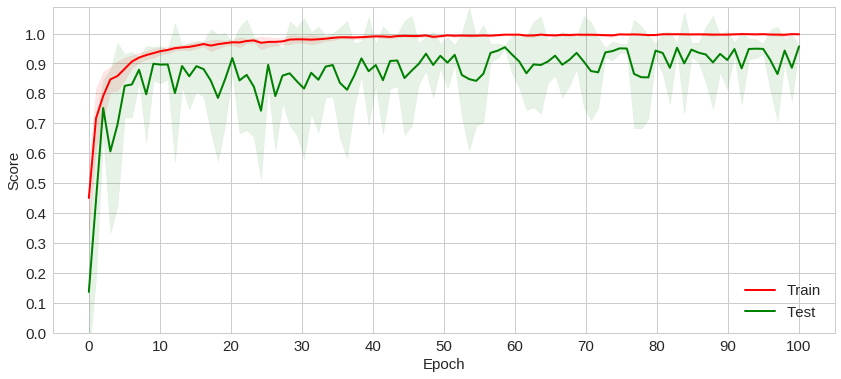

In [36]:
plot_mean_acc(hist)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

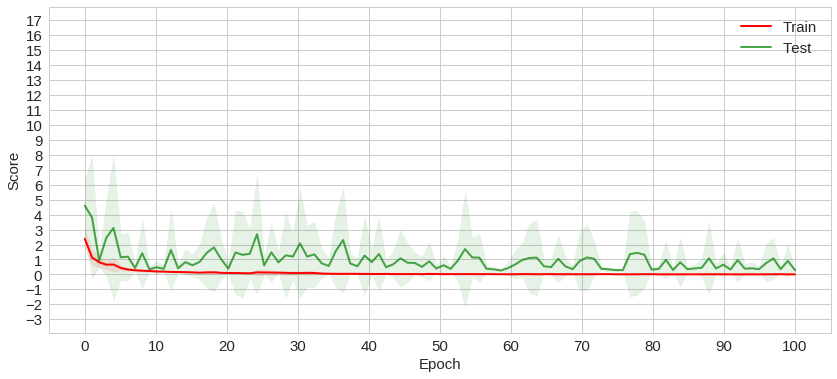

In [38]:
plot_mean_loss(hist)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-10, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

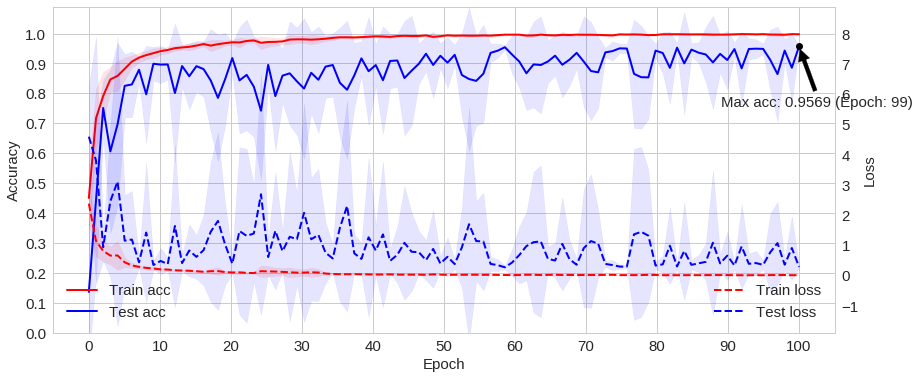

In [48]:
plot_mean(hist)